In [1]:
!pip install -q matplotlib

import json
import os
import glob
import time                                                                                                             

from PIL import Image
import torch
import numpy as np

from matplotlib import pyplot as plt

import kaolin as kal

from PIL import Image

import nvdiffrast
nvctx = nvdiffrast.torch.RasterizeGLContext(device='cuda')
import torchvision
from torchvision.io import decode_image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import save_image



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Warp 1.4.2 initialized:
   CUDA Toolkit 12.6, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3050 Laptop GPU" (4 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/bhartrhari/.cache/warp/1.4.2


/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [2]:
maxtilex = 4
maxtiley = 4
scheduler_step_size = 20
scheduler_gamma = 0.5
res =1024
num_light = 5

texture_res = 400
width = 1824//maxtilex
height = 2736//maxtiley
learn_light = False

if learn_light:

    amplitude = torch.ones(num_light,1,3,requires_grad=True,device="cuda")
    with torch.no_grad():
        source =  torch.tensor([-5,5,-5]).cuda()
        amplitude[:] = amplitude*200
        
    source.requires_grad = True
    amplitude.requires_grad = True
else:
    amplitude, source = torch.load("./lighting_param.pt",weights_only=True)

"""
azimuth = torch.zeros(num_light,1,requires_grad=True,device="cuda")
elevation = torch.fill(torch.zeros(num_light,1),torch.pi)
elevation=elevation.cuda()
elevation.requires_grad=True


amplitude = torch.ones(num_light,1,3,requires_grad=True,device="cuda")
with torch.no_grad():
    amplitude[:] = amplitude[:]*20
sharpness =torch.ones(num_light,1,requires_grad=True,device="cuda") 



try:
    amplitude,sharpness,azimuth,elevation = torch.load("./lighting_param.pt")
except:
    print("Could not load the parameters")
print(amplitude)"""

'\nazimuth = torch.zeros(num_light,1,requires_grad=True,device="cuda")\nelevation = torch.fill(torch.zeros(num_light,1),torch.pi)\nelevation=elevation.cuda()\nelevation.requires_grad=True\n\n\namplitude = torch.ones(num_light,1,3,requires_grad=True,device="cuda")\nwith torch.no_grad():\n    amplitude[:] = amplitude[:]*20\nsharpness =torch.ones(num_light,1,requires_grad=True,device="cuda") \n\n\n\ntry:\n    amplitude,sharpness,azimuth,elevation = torch.load("./lighting_param.pt")\nexcept:\n    print("Could not load the parameters")\nprint(amplitude)'

In [3]:
def srgb_to_linear(image_tensor: torch.Tensor) -> torch.Tensor:
    """
    Converts a batch of sRGB image tensors to linear RGB.
    
    Formula:
    if C <= 0.04045: L = C / 12.92
    if C > 0.04045:  L = ((C + 0.055) / 1.055) ** 2.4
    
    Args:
        image_tensor: A tensor (e.g., shape [B, C, H, W]) in sRGB space [0, 1].

    Returns:
        A tensor of the same shape in linear RGB space.
    """

    # Values for the linear part of the sRGB curve
    limit = 0.04045
    
    # torch.where(condition, value_if_true, value_if_false)
    return torch.where(
        image_tensor <= limit,
        image_tensor / 12.92,
        torch.pow((image_tensor + 0.055) / 1.055, 2.4)
    )

def linear_to_srgb(image_tensor: torch.Tensor, epsilon: float = 1e-6)-> torch.Tensor:
    """
    Converts a batch of linear RGB image tensors to sRGB.
    
    Formula:
    if L <= 0.0031308: C = L * 12.92
    if L > 0.0031308:  C = 1.055 * (L ** (1/2.4)) - 0.055
    
    Args:
        image_tensor: A tensor (e.g., shape [B, C, H, W]) in linear RGB [0, 1].
        epsilon: A small value to add before the power function 
                 to avoid NaNs when backpropagating gradients through zero.

    Returns:
        A tensor of the same shape in sRGB space.
    """
    # Values for the linear part of the sRGB curve
    limit = 0.0031308

    # Add epsilon for numerical stability, clamp to avoid negative values
    # from floating point inaccuracies before the power function.
    linear_clipped = torch.clamp(image_tensor, min=0.0)
    
    # torch.where(condition, value_if_true, value_if_false)
    return torch.where(
        linear_clipped <= limit,
        linear_clipped * 12.92,
        1.055 * torch.pow(linear_clipped + epsilon, 1.0 / 2.4) - 0.055
    )

In [4]:
p = torch.load("./saved_cam_trans.pt",weights_only=False)

print(p[0])
intr = torch.load("./saved_cam_int.pt",weights_only=False)
height2, width2 = torch.load("./saved_cam_hw.pt")

tensor([[ 1.0000,  0.0000,  0.0000, -0.0050],
        [ 0.0000,  0.9964, -0.0847,  0.0317],
        [-0.0000,  0.0847,  0.9964, -1.9972],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


/tmp/ipykernel_364574/1872595950.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  height2, width2 = torch.load("./saved_cam_hw.pt")


In [5]:
cam2 = kal.render.camera.Camera.from_args(view_matrix = p, focal_x = intr[0,2]/width2*width,focal_y = intr[0,3]/height2*height,width = width, height = height)


In [6]:
mesh = kal.io.gltf.import_mesh('./scan_mesh_working/scan_mesh_3.glb').cuda()
#mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices.unsqueeze(0), normalize=False).squeeze(0)

game_mesh = kal.io.gltf.import_mesh('./scan_mesh_working/game_mesh.glb').cuda()
#game_mesh.vertices = kal.ops.pointcloud.center_points(game_mesh.vertices.unsqueeze(0), normalize=False).squeeze(0)

/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/kaolin/io/gltf.py:285: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/torch/csrc/utils/tensor_new.cpp:1560.)
  output = torch.frombuffer(


In [7]:
"""image = Image.open("./game_mesh/melanie_liburd_default_head_d.tga")
game_diffuse = torch.tensor(image.getdata()).reshape(1,image.size[0],image.size[1],3).cuda().float()/255
image = Image.open("./game_mesh/melanie_liburd_default_head_n.tga")
game_normal = torch.tensor(image.getdata()).reshape(1,image.size[0],image.size[1],3).cuda().float()/255
image = Image.open("./game_mesh/melanie_liburd_default_head_sa.tga")
game_reflect =   torch.tensor(image.getdata()).reshape(1,image.size[0],image.size[1],3).cuda().float()/255"""



'image = Image.open("./game_mesh/melanie_liburd_default_head_d.tga")\ngame_diffuse = torch.tensor(image.getdata()).reshape(1,image.size[0],image.size[1],3).cuda().float()/255\nimage = Image.open("./game_mesh/melanie_liburd_default_head_n.tga")\ngame_normal = torch.tensor(image.getdata()).reshape(1,image.size[0],image.size[1],3).cuda().float()/255\nimage = Image.open("./game_mesh/melanie_liburd_default_head_sa.tga")\ngame_reflect =   torch.tensor(image.getdata()).reshape(1,image.size[0],image.size[1],3).cuda().float()/255'

In [8]:
# game_diffuse2 = decode_image("./game_mesh/melanie_liburd_default_head_d.png").cuda().float()/255
# game_normal2 = decode_image("./game_mesh/melanie_liburd_default_head_n.png").cuda().float()/255
# game_reflect2 = decode_image("./game_mesh/melanie_liburd_default_head_sa.png").cuda().float()/255
# game_roughness2 = decode_image("./game_mesh/melanie_liburd_default_head_s.png").cuda().float()/255

In [9]:
# game_diffuse = torch.permute(game_diffuse2,(1,2,0)).unsqueeze(0)
# game_normal = torch.permute(game_normal2,(1,2,0)).unsqueeze(0)
# game_F0 = torch.pow(torch.permute(game_reflect2,(1,2,0)).unsqueeze(0),2.2)
# game_roughness = 1-torch.permute(game_roughness2,(1,2,0)).unsqueeze(0)

# print(game_diffuse.shape)
# print(torch.max(game_diffuse))

In [38]:
with torch.no_grad():
    materials = torch.rand([1,res,res,3],requires_grad=True).cuda()*0.+torch.tensor([255, 139, 85]).cuda()/255

    
    
materials.requires_grad=True
grad_boost = 5e2
materials.register_hook(lambda grad: grad*grad_boost)


mesh.uvs = torch.nn.functional.pad(mesh.uvs, (0, 0, 0, 1))
mesh.face_uvs_idx[mesh.face_uvs_idx == -1] = mesh.uvs.shape[1] - 1

game_mesh.uvs = torch.nn.functional.pad(game_mesh.uvs, (0, 0, 0, 1))
game_mesh.face_uvs_idx[game_mesh.face_uvs_idx == -1] = game_mesh.uvs.shape[1] - 1


In [39]:
with torch.no_grad():
    roughness = torch.ones([1,res,res,1], device='cuda',requires_grad=True)*0.5
roughness.requires_grad = True

In [40]:
reflectence = torch.ones_like(roughness).cuda()*0.5
reflectence.requires_grad=True
with torch.no_grad():
    F0 = torch.ones_like(materials).cuda()*0.04
F0.requires_grad=True

In [41]:
shadow_fac = torch.tensor([0.5], requires_grad=True, device="cuda")

In [42]:



with torch.no_grad():
    bump_map = torch.tensor([0.5,0.5,1.]).repeat([1,res,res,1]).cuda()
    """
    n = Image.open("./normals.png")
    n = torch.tensor(n.getdata()).reshape(n.size[0],n.size[1],3)
    plt.imshow(n)

    bump_map = n.float()/255.*2-1.
    bump_map = bump_map.unsqueeze(0).cuda()
    """
    
bump_map.requires_grad=True
print(materials.shape)
print(bump_map.shape)
spec_texture = torch.tensor([1.,1.,1.]).repeat(1,512,512,1).cuda()

print(spec_texture.shape)
print(roughness.shape)
print(game_mesh.uvs.shape)
print(roughness.requires_grad)


torch.Size([1, 1024, 1024, 3])
torch.Size([1, 1024, 1024, 3])
torch.Size([1, 512, 512, 3])
torch.Size([1, 1024, 1024, 1])
torch.Size([32575, 2])
True


In [43]:
with torch.no_grad():
    bump_map_scan = torch.tensor([0.5,0.5,1.]).repeat([1,1024,1024,1]).cuda()
bump_map_scan.requires_grad=True
reflectence_scan = torch.ones_like(reflectence).cuda()*0.04
reflectence_scan.requires_grad=True
with torch.no_grad():
    roughness_scan = torch.ones([1,1024,1024,1], device='cuda',requires_grad=True)*0.5
roughness_scan.requires_grad = True

In [44]:
with torch.no_grad():
    im = []
    for i in range(num_light):
        
        image = Image.open(f"./OLAT_ColourCorrected_PNG/OLAT_0{30+2*i}.png")
        
        im_re = torchvision.transforms.functional.to_tensor(image)
        #im_re = torch.permute(im_re,(1,2,0))
        im.append(im_re)
        
    im_target2 = torch.stack(im)
    print(image.size[0],image.size[1],im_target2.shape,torch.max(im_target2[:]/255))

    #im_target = im_target.unsqueeze(0)
    #im_target = torch.transpose(torch.transpose(im_target,1,3),2,3)
    print(im_target2.shape)
    b = torchvision.transforms.Resize([height,width])


1824 2736 torch.Size([5, 3, 2736, 1824]) tensor(0.0039)
torch.Size([5, 3, 2736, 1824])


1824 2736 torch.Size([5, 684, 456, 3]) tensor(1.)
torch.float32
torch.Size([5, 2736, 1824, 3])


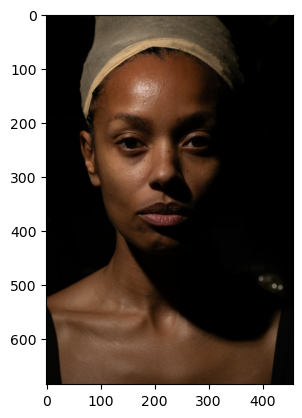

In [45]:
with torch.no_grad():
    im_target = b.forward(im_target2)
    #im_target = torch.flip(im_target,dims=[3])
    im_target = torch.transpose(torch.transpose(im_target,2,3),1,3)
with torch.no_grad():
    
    im_target = im_target
    #im_target = torch.pow(im_target, 0.454)
    plt.imshow(im_target[0].cpu())
    print(image.size[0],image.size[1],im_target.shape,torch.max(im_target[:]))
    print(im_target.dtype)      


im_target = im_target.cuda()
im_target2 = torch.permute(im_target2,(0,2,3,1)).cuda()
print(im_target2.shape)

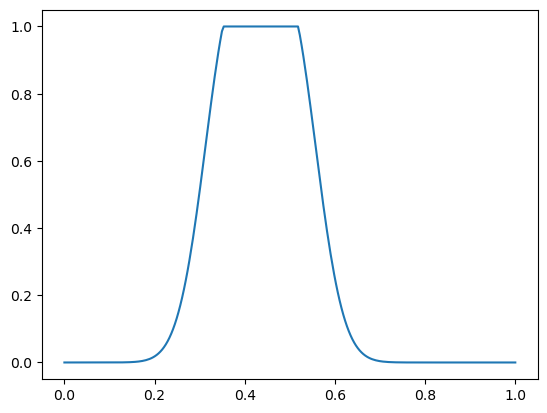

In [46]:
weights = torch.tensor([0.2126,0.7152,0.0722]).cuda()

def srgb_to_oklab(im):
    M1 = torch.tensor([[0.4122214708,0.5363325363,0.0514459929],
                   [0.2119034982,0.6806995451,0.1073969566],
                   [0.0883024619,0.2817188376,0.6299787005]]).cuda()
    M2 = torch.tensor([[0.2104542553,0.7936177850, -0.0040720468],
        [1.9779984951,-2.4285922050,0.4505937099],
        [0.0259040371,0.7827717662,-0.8086757660]]).cuda()

    return (M2@torch.pow(M1@srgb_to_linear(im).unsqueeze(-1),1/3)).squeeze(-1)



def gaussian(x,mean=0.37, var=0.06):
    return torch.exp(-(x-mean)**2/(2*var**2))
x = torch.linspace(0,1,250)
y = gaussian(x)+gaussian(x,mean=0.5)
y = torch.clamp(y,0.,1.)
plt.plot(x,y)


tensor([0.6280, 0.2249, 0.1258], device='cuda:0')
tensor(0.3739, device='cuda:0')
tensor(0.9999, device='cuda:0')
tensor(0.0058, device='cuda:0')
torch.Size([5, 684, 456, 1])


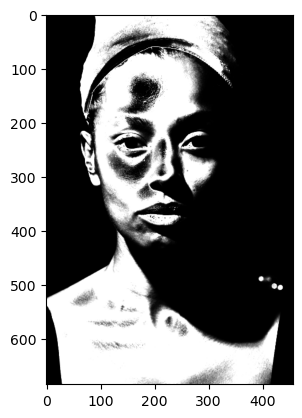

In [47]:
print(srgb_to_oklab(torch.tensor([1,0,0]).cuda()))

percieved_lum = srgb_to_oklab(im_target)[:,:,:,0]

print(torch.mean(percieved_lum[percieved_lum>0.1]))
print(torch.max(percieved_lum))
print(torch.min(percieved_lum))

weights_loss = gaussian(percieved_lum).unsqueeze(-1)+gaussian(percieved_lum,mean=0.5).unsqueeze(-1)
weights_loss = torch.clamp(weights_loss,0.,1.)
plt.imshow(weights_loss[0].cpu().detach().repeat(1,1,3))
print(weights_loss.shape)

torch.Size([5, 684, 456, 1])


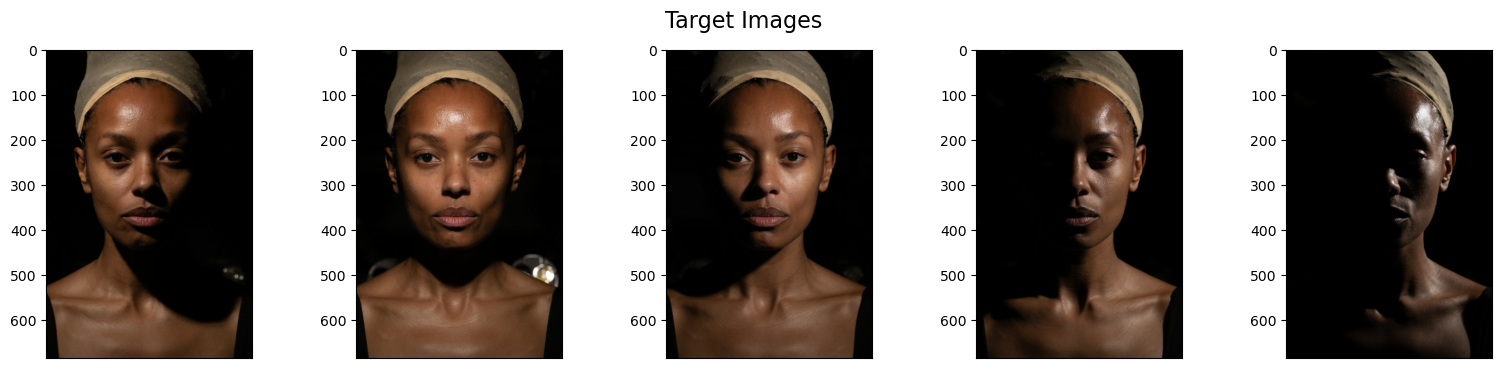

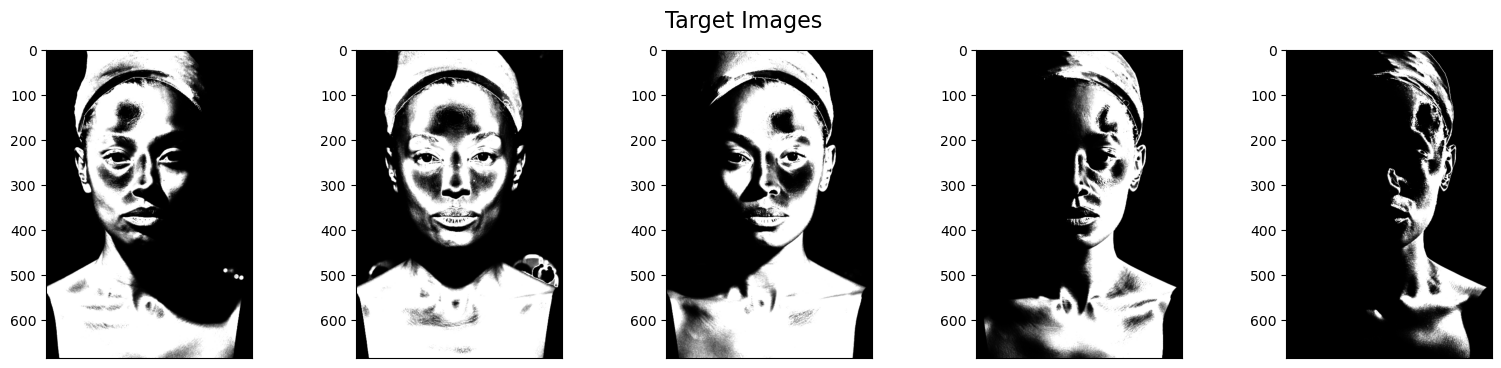

In [48]:
def disp_target(imgs,title="Target Images"):
    n = imgs.shape[0]

    f, axes = plt.subplots(1,n,figsize=(4 * n, 4. * 1                                                   ))
    f.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0., hspace=0.1)
    for i in range(n):
        if imgs.shape[0]>i:
            axes[i].imshow(imgs[i].cpu().detach(),cmap='Grays')
            axes[i].set_xticks([])
disp_target(im_target)
percieved_lum = percieved_lum.unsqueeze(-1)
print(percieved_lum.shape)
disp_target(weights_loss.repeat(1,1,1,3))

In [49]:
import copy
_, per_cam_to_ray_d = kal.render.camera.generate_pinhole_rays(cam2)
ray_d = -per_cam_to_ray_d.reshape(1,cam2.height, cam2.width, 3)
ray_d = ray_d/torch.norm(ray_d,dim=-1,keepdim=True)


cam3 = copy.deepcopy(cam2)
cam3.height = im_target2.shape[1]
cam3.width = im_target2.shape[2]
_, per_cam_to_ray_d = kal.render.camera.generate_pinhole_rays(cam3)
ray_ds = -per_cam_to_ray_d.reshape(1,cam3.height, cam3.width, 3)
ray_ds = ray_ds/torch.norm(ray_ds,dim=-1,keepdim=True)

print(cam2.height,cam3.height)


684 2736


In [50]:
def light(vertices_clip, source, amlitude):
    direction = source-vertices_clip[:,:,:3] 
    dist = torch.norm(direction,dim=-1,keepdim=True)
    direction = direction / dist
    power = amplitude/torch.pow(dist, 2)
    #print(torch.norm(power,dim=-1))
    return direction,power

In [51]:
def shadow_mask_rast(mesh, cam,rast_zw):

    rast_zw = rast_zw/rast_zw[:,:,-1:]
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    
    
    pix_proj = (cam.extrinsics.view_matrix()@rast_zw)
    

    #hom_pix = kal.render.camera.up_to_homogeneous(pix_proj)[..., None]
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]
    #print(proj,"Projection")
    vertices_clip2 = (proj @ homogeneous_vecs).squeeze(-1)
    vertices_clip = (proj @ pix_proj).squeeze(-1)
    
    #print(vertices_clip.shape,"VERT_Shape")
    
    #kaolin.render.mesh.dibr_rasterization(height, width, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='cuda')¶
    
    
    
    
    with nvdiffrast.torch.DepthPeeler(nvctx, vertices_clip2, mesh.faces.int(),  (cam.height, cam.width),grad_db=True) as peeler:
        rast,_=peeler.rasterize_next_layer()
        vertices_clip = vertices_clip/vertices_clip[:,:,3:4]
        #print(torch.max(vertices_clip[:]),torch.min(vertices_clip[:]),"MAX,MIN")

        
        
        z = (vertices_clip[:,:,2:3] / vertices_clip[:,:,3:4])
        comp_z = torch.nn.functional.grid_sample(rast[:,:,:,2].unsqueeze(0),vertices_clip[:,:,:2].unsqueeze(0),padding_mode="zeros").squeeze(0).squeeze(0).unsqueeze(-1)
        
        # xy_mask = (x>=0) * (x<cam.width) * (y>=0) * (y<cam.height)
        # x = torch.clamp(x,0.,cam.width-1)
        # y = torch.clamp(y,0.,cam.height-1)
        
        # #print(torch.all(x.int()>=0).int()==torch.ones_like(x.int()))
        # comp_z = rast[0,y.int(),x.int(),-2:-1]
        
        
        #print(comp_z.shape, z.shape)
        #print(torch.min(comp_z),torch.min(z),torch.max(comp_z),torch.max(z))
        
        comp_z=comp_z
        z = z
        #print(comp_z.shape,z.shape,"COMPARE")
        #print((comp_z<(z-1e-5)).shape,"X_SHAPE")
        assert(comp_z.shape==z.shape)
        mask = (comp_z<(z-0.0000025))
        return mask.float()
        #print(vertices_clip[((comp_z-z)<0).squeeze(-1),:].shape)
        #print(z-comp_z)
        #print(mask.shape,"MASK_SHAPE")
        occ = torch.nonzero(torch.all(torch.isin(mesh.faces,mask),dim=1))
        return (occ+1).flatten()


In [52]:
def shadow_mask(mesh, source,width,height,cam_rast_zw=torch.tensor([[1.],[2.],[3.],[4]]).cuda().unsqueeze(0).squeeze(-1),device="cuda"):
    source=source.squeeze(0)
    
    pos = source
    up_z = [1.,0.,0.] 
    up_x = [0.,1.,0.]
    up_y = [0.,0.,1.]
    at_zp = source+torch.tensor([0.,0.,1.],device=device)
    at_zm =  source+torch.tensor([0.,0.,-1.],device=device)
    at_yp =  source+torch.tensor([0.,1.,0.],device=device)
    at_ym =  source+torch.tensor([0.,-1.,0.],device=device)
    at_xp =  source+torch.tensor([1.,0.,0.],device=device)
    at_xm =  source+torch.tensor([-1.,0.,0.],device=device)
    fov = torch.tensor([torch.pi/2])
    camera_zp = kal.render.camera.Camera.from_args(eye=pos, at=at_zp, up = up_z, fov=fov, width = width, height = height,device = device)
    camera_zm = kal.render.camera.Camera.from_args(eye=pos, at=at_zm, up = up_z, fov=fov, width = width, height = height,device = device)
    camera_yp = kal.render.camera.Camera.from_args(eye=pos, at=at_yp, up = up_y, fov=fov, width = width, height = height,device = device)
    camera_ym = kal.render.camera.Camera.from_args(eye=pos, at=at_ym, up = up_y, fov=fov, width = width, height = height,device = device)
    camera_xp = kal.render.camera.Camera.from_args(eye=pos, at=at_xp, up = up_x, fov=fov, width = width, height = height,device = device)
    camera_xm = kal.render.camera.Camera.from_args(eye=pos, at=at_xm, up = up_x, fov=fov, width = width, height = height,device = device)

    cameras = [camera_zp,camera_zm,camera_yp,camera_ym,camera_xp,camera_xm]
    #print(camera_xm.view_matrix())
    tid = torch.ones_like(cam_rast_zw).cuda().squeeze(-1)[:,:,:3]
    for cam in cameras:
        mask = shadow_mask_rast(mesh, cam, cam_rast_zw)
        #print(tid.shape,mask.shape,"FINAL")
        tid = tid*mask
        #print(torch.nonzero(1-mask),"NON_ZERO")

    #print(torch.min(tid),"TID")
    return torch.clamp(tid,0.,1.)


In [53]:
#shadow_mask(mesh,torch.tensor([1,0,0]).cuda(),2048,2048)

In [54]:

import torch.nn as nn
import torch.nn.functional as F
import math

class OpenPBRShader(nn.Module):
    """
    Complete OpenPBR shader implementation in PyTorch.
    
    This implementation follows the OpenPBR specification for physically-based rendering,
    including base layer, metalness, transmission, subsurface, coat, and emission.
    """
    
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.eps = 1e-8
        
    def fresnel_schlick(self, cos_theta, f0, f90=1.0):
        """Schlick's approximation of the Fresnel reflection coefficient"""
        cos_theta = torch.clamp(cos_theta, 0.0, 1.0)
        return f0 + (f90 - f0) * torch.pow(1.0 - cos_theta, 5.0)
    
    def fresnel_dielectric(self, cos_theta_i, ior):
        """Exact Fresnel reflection for dielectrics"""
        cos_theta_i = torch.clamp(cos_theta_i, -1.0, 1.0)
        
        # Handle total internal reflection
        sin_theta_t_sq = (1.0 / (ior * ior)) * (1.0 - cos_theta_i * cos_theta_i)
        
        # Check for total internal reflection
        tir_mask = sin_theta_t_sq >= 1.0
        
        cos_theta_t = torch.sqrt(torch.clamp(1.0 - sin_theta_t_sq, 0.0, 1.0))
        
        # Fresnel equations
        rs_num = ior * cos_theta_i - cos_theta_t
        rs_den = ior * cos_theta_i + cos_theta_t
        rs = (rs_num / (rs_den + self.eps)) ** 2
        
        rp_num = cos_theta_i - ior * cos_theta_t
        rp_den = cos_theta_i + ior * cos_theta_t
        rp = (rp_num / (rp_den + self.eps)) ** 2
        
        reflectance = 0.5 * (rs + rp)
        
        # Handle total internal reflection
        reflectance = torch.where(tir_mask, torch.ones_like(reflectance), reflectance)
        
        return reflectance
    
    def ggx_distribution(self, n_dot_h, roughness):
        """GGX/Trowbridge-Reitz normal distribution function"""
        alpha = roughness * roughness
        alpha2 = alpha * alpha
        denom = n_dot_h * n_dot_h * (alpha2 - 1.0) + 1.0
        return alpha2 / (math.pi * denom * denom + self.eps)
    
    def smith_masking_function(self, n_dot_v, roughness):
        """Smith masking function for GGX distribution"""
        alpha = roughness * roughness
        alpha2 = alpha * alpha
        lambda_v = (-1.0 + torch.sqrt(1.0 + alpha2 * (1.0 - n_dot_v * n_dot_v) / (n_dot_v * n_dot_v + self.eps))) / 2.0
        return 1.0 / (1.0 + lambda_v)
    
    def ggx_geometry(self, n_dot_l, n_dot_v, roughness):
        """GGX geometry function (Smith model)"""
        g1_l = self.smith_masking_function(n_dot_l, roughness)
        g1_v = self.smith_masking_function(n_dot_v, roughness)
        return g1_l * g1_v
    
    def lambert_diffuse(self, albedo):
        """Lambert diffuse BRDF"""
        return albedo / math.pi
    
    def oren_nayar_diffuse(self, albedo, roughness, n_dot_l, n_dot_v, l_dot_v):
        """Oren-Nayar diffuse BRDF for rough surfaces"""
        sigma = roughness
        sigma2 = sigma * sigma
        
        A = 1.0 - 0.5 * sigma2 / (sigma2 + 0.33)
        B = 0.45 * sigma2 / (sigma2 + 0.09)
        
        theta_i = torch.acos(torch.clamp(n_dot_l, 0.0, 1.0))
        theta_r = torch.acos(torch.clamp(n_dot_v, 0.0, 1.0))
        
        alpha = torch.max(theta_i, theta_r)
        beta = torch.min(theta_i, theta_r)
        
        cos_phi_diff = torch.clamp(l_dot_v - n_dot_l * n_dot_v, -1.0, 1.0)
        
        return albedo / math.pi * (A + B * torch.max(torch.zeros_like(cos_phi_diff), cos_phi_diff) * 
                                   torch.sin(alpha) * torch.tan(beta))
    
    def subsurface_scattering(self, albedo, radius, n_dot_l):
        """Simplified subsurface scattering approximation"""
        # Jensen's dipole approximation (simplified)
        scatter = torch.exp(-1.0 / (radius + self.eps)) * albedo
        wrap_lighting = torch.pow(torch.clamp(n_dot_l * 0.5 + 0.5, 0.0, 1.0), 2.0)
        return scatter * wrap_lighting
    
    def compute_base_layer(self, material, geometry, lighting):
        """Compute base layer (metallic/dielectric) contribution"""
        base_color = material['base_color']
        metallic = material['metallic']
        roughness = torch.clamp(material['roughness'], 0.04, 1.0)
        ior = material.get('ior', 1.5)
        
        n_dot_l = torch.clamp(geometry['n_dot_l'], 0.0, 1.0)
        n_dot_v = torch.clamp(geometry['n_dot_v'], 0.0, 1.0)
        n_dot_h = torch.clamp(geometry['n_dot_h'], 0.0, 1.0)
        v_dot_h = torch.clamp(geometry['v_dot_h'], 0.0, 1.0)
        l_dot_v = geometry['l_dot_v']
        
        # Fresnel reflectance
        if material.get('F0',None) == None:
            f0_dielectric = ((ior - 1.0) / (ior + 1.0)) ** 2
            f0_metal = base_color
            f0 = torch.lerp(f0_dielectric, f0_metal, metallic)
        else:
            f0_dielectric = material.get('F0',None)
            f0_metal = base_color
            f0 = torch.lerp(f0_dielectric, f0_metal, metallic)
        
        fresnel = self.fresnel_schlick(v_dot_h, f0)
        
        # Microfacet distribution
        D = self.ggx_distribution(n_dot_h, roughness)
        
        # Geometry function
        G = self.ggx_geometry(n_dot_l, n_dot_v, roughness)
        
        # Specular BRDF
        specular_numerator = D * G * fresnel
        specular_denominator = 4.0 * n_dot_v * n_dot_l + self.eps
        specular = specular_numerator / specular_denominator
        
        # Diffuse component (only for dielectrics)
        kS = fresnel
        kD = (1.0 - kS) * (1.0 - metallic)
        
        # Choose diffuse model based on roughness
        if material.get('use_oren_nayar', False):
            
            diffuse = self.oren_nayar_diffuse(base_color, roughness, n_dot_l, n_dot_v, l_dot_v)
        else:
            
            diffuse = self.lambert_diffuse(base_color)
        
        # Combine diffuse and specular
        brdf = kD * diffuse + specular
        radiance = brdf * lighting['intensity'] * n_dot_l
        
        return {
            'radiance': radiance,
            'fresnel': fresnel,
            'kD': kD,
            'kS': kS
        }
    
    def compute_transmission(self, material, geometry, lighting, base_result):
        """Compute transmission through the material"""
        transmission_weight = material.get('transmission_weight', 0.0)
        transmission_color = material.get('transmission_color', torch.ones_like(material['base_color']))
        ior = material.get('ior', 1.5)
        roughness = torch.clamp(material['roughness'], 0.04, 1.0)
        
        if transmission_weight <= 0.0:
            return torch.zeros_like(base_result['radiance'])
        
        n_dot_v = torch.clamp(geometry['n_dot_v'], 0.0, 1.0)
        
        # Fresnel for transmission
        fresnel = self.fresnel_dielectric(n_dot_v, ior)
        transmission_factor = (1.0 - fresnel) * transmission_weight
        
        # Simplified transmission (should include refraction and volume scattering)
        transmitted_light = lighting['intensity'] * transmission_color * transmission_factor
        
        return transmitted_light
    
    def compute_subsurface(self, material, geometry, lighting):
        """Compute subsurface scattering contribution"""
        subsurface_weight = material.get('subsurface_weight', 0.0)
        subsurface_color = material.get('subsurface_color', material['base_color'])
        subsurface_radius = material.get('subsurface_radius', 0.1)
        
        if subsurface_weight <= 0.0:
            return torch.zeros_like(material['base_color'])
        
        n_dot_l = geometry['n_dot_l']
        
        subsurface_contrib = self.subsurface_scattering(
            subsurface_color, 
            subsurface_radius, 
            n_dot_l
        )
        
        return subsurface_contrib * subsurface_weight * lighting['intensity']
    
    def compute_coat(self, material, geometry, lighting, base_radiance):
        """Compute coat layer contribution"""
        coat_weight = material.get('coat_weight', 0.0)
        coat_color = material.get('coat_color', torch.ones_like(material['base_color']))
        coat_roughness = torch.clamp(material.get('coat_roughness', 0.0), 0.0, 1.0)
        coat_ior = material.get('coat_ior', 1.5)
        
        if coat_weight <= 0.0:
            return base_radiance
        
        n_dot_l = torch.clamp(geometry['n_dot_l'], 0.0, 1.0)
        n_dot_v = torch.clamp(geometry['n_dot_v'], 0.0, 1.0)
        n_dot_h = torch.clamp(geometry['n_dot_h'], 0.0, 1.0)
        v_dot_h = torch.clamp(geometry['v_dot_h'], 0.0, 1.0)
        
        # Coat Fresnel
        f0_coat = ((coat_ior - 1.0) / (coat_ior + 1.0)) ** 2
        coat_fresnel = self.fresnel_schlick(v_dot_h, f0_coat)
        
        # Coat specular
        coat_D = self.ggx_distribution(n_dot_h, coat_roughness)
        coat_G = self.ggx_geometry(n_dot_l, n_dot_v, coat_roughness)
        
        coat_specular_num = coat_D * coat_G * coat_fresnel
        coat_specular_den = 4.0 * n_dot_v * n_dot_l + self.eps
        coat_specular = coat_specular_num / coat_specular_den
        
        coat_radiance = coat_specular * coat_color * lighting['intensity'] * n_dot_l * coat_weight
        
        # Attenuate base layer by coat
        coat_attenuation = 1.0 - coat_fresnel * coat_weight
        attenuated_base = base_radiance * coat_attenuation
        
        return attenuated_base + coat_radiance
    
    def compute_emission(self, material):
        """Compute emission contribution"""
        emission_luminance = material.get('emission_luminance', 0.0)
        emission_color = material.get('emission_color', torch.ones_like(material['base_color']))
        
        return emission_color * emission_luminance
    
    def forward(self, material, geometry, lighting):
        """
        Main shader evaluation function
        
        Args:
            material: Dictionary containing material parameters
                - base_color: Base albedo color [batch_size, 3]
                - metallic: Metallic factor [batch_size, 1] or [batch_size, 3]
                - roughness: Surface roughness [batch_size, 1]
                - ior: Index of refraction [batch_size, 1]
                - transmission_weight: Transmission strength [batch_size, 1]
                - transmission_color: Transmission color [batch_size, 3]
                - subsurface_weight: Subsurface scattering weight [batch_size, 1]
                - subsurface_color: Subsurface scattering color [batch_size, 3]
                - subsurface_radius: Subsurface scattering radius [batch_size, 1]
                - coat_weight: Coat layer weight [batch_size, 1]
                - coat_color: Coat layer color [batch_size, 3]
                - coat_roughness: Coat layer roughness [batch_size, 1]
                - coat_ior: Coat layer IOR [batch_size, 1]
                - emission_luminance: Emission strength [batch_size, 1]
                - emission_color: Emission color [batch_size, 3]
                
            geometry: Dictionary containing geometric information
                - n_dot_l: Normal dot light direction [batch_size, 1]
                - n_dot_v: Normal dot view direction [batch_size, 1]
                - n_dot_h: Normal dot half vector [batch_size, 1]
                - v_dot_h: View dot half vector [batch_size, 1]
                - l_dot_v: Light dot view vector [batch_size, 1]
                
            lighting: Dictionary containing lighting information
                - intensity: Light intensity [batch_size, 3]
                
        Returns:
            Dictionary containing:
                - radiance: Final shaded color [batch_size, 3]
                - base_radiance: Base layer contribution
                - transmission: Transmission contribution
                - subsurface: Subsurface contribution
                - coat_radiance: Coat layer contribution
                - emission: Emission contribution
        """
        
        # Compute base layer (metallic/dielectric)
        base_result = self.compute_base_layer(material, geometry, lighting)
        base_radiance = base_result['radiance']
        
        # Compute transmission
        transmission = self.compute_transmission(material, geometry, lighting, base_result)
        
        # Compute subsurface scattering
        subsurface = self.compute_subsurface(material, geometry, lighting)
        
        # Combine base, transmission, and subsurface
        combined_base = base_radiance + transmission + subsurface
        
        # Apply coat layer
        final_radiance = self.compute_coat(material, geometry, lighting, combined_base)
        
        # Add emission
        emission = self.compute_emission(material)
        final_radiance = final_radiance + emission
        
        return {
            'radiance': final_radiance,
            'base_radiance': base_radiance,
            'transmission': transmission,
            'subsurface': subsurface,
            'coat_radiance': final_radiance - combined_base,
            'emission': emission,
            'fresnel': base_result['fresnel'],
            'kD': base_result['kD'],
            'kS': base_result['kS']
        }


# Example usage and utility functions
def create_geometry_vectors(normal, light_dir, view_dir):
    """
    Create geometry vectors needed for shading
    
    Args:
        normal: Surface normal [batch_size, 3]
        light_dir: Light direction [batch_size, 3] 
        view_dir: View direction [batch_size, 3]
        
    Returns:
        Dictionary with dot products
    """
    # Normalize vectors
    N = F.normalize(normal, dim=-1)
    L = F.normalize(light_dir, dim=-1)
    V = F.normalize(view_dir, dim=-1)
    H = F.normalize(L + V, dim=-1)
    
    # Compute dot products
    n_dot_l = torch.sum(N * L, dim=-1, keepdim=True)
    n_dot_v = torch.sum(N * V, dim=-1, keepdim=True)
    n_dot_h = torch.sum(N * H, dim=-1, keepdim=True)
    v_dot_h = torch.sum(V * H, dim=-1, keepdim=True)
    l_dot_v = torch.sum(L * V, dim=-1, keepdim=True)
    
    return {
        'n_dot_l': n_dot_l,
        'n_dot_v': n_dot_v,
        'n_dot_h': n_dot_h,
        'v_dot_h': v_dot_h,
        'l_dot_v': l_dot_v
    }

def create_default_material(batch_size, base_colour,roughness,reflectence,f0,device='cpu'):
    """Create a default material dictionary"""
    return {
        'base_color': base_colour,
        'metallic': reflectence,
        'roughness': roughness,
        'ior': torch.full((batch_size, 1), 1.4, device=device),
        'transmission_weight': torch.zeros(batch_size, 1, device=device),
        'transmission_color': torch.ones(batch_size, 3, device=device),
        'subsurface_weight': torch.ones(batch_size, 1, device=device)*0.0,
        'subsurface_color': base_colour,
        'subsurface_radius': torch.full((batch_size, 1), 0.1, device=device),
        'coat_weight': torch.ones(batch_size, 1, device=device)*0.2,
        'coat_color': torch.ones(batch_size, 3, device=device),
        'coat_roughness': torch.zeros(batch_size, 1, device=device),
        'coat_ior': torch.full((batch_size, 1), 1.5, device=device),
        'emission_luminance': torch.zeros(batch_size, 1, device=device),
        'emission_color': torch.ones(batch_size, 3, device=device),
        'use_oren_nayar':False,
        'F0': f0
    }


    

In [55]:
def get_rast(mesh,cam,tilex=0,tiley=0,maxtilex=1,maxtiley=1):
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)
    
    #print(vertices_clip.shape,(torch.tensor([0.1,0,0,0])*w).shape)
    
    
    if maxtilex>1 and maxtiley>1:
        w = (vertices_clip[:,:,3]).unsqueeze(-1)
        xshift = (tilex/maxtilex*2-1+1/(maxtilex))
        yshift = (tiley/maxtiley*2-1+1/(maxtiley))
        vertices_clip = vertices_clip-(torch.tensor([xshift,-yshift,0,0]).cuda()*w)
        vertices_clip = vertices_clip*torch.tensor([maxtilex,maxtiley,1,1]).cuda()
    
    rast = nvdiffrast.torch.rasterize(
        nvctx, vertices_clip, mesh.faces.int(),
        (cam.height, cam.width), grad_db=True
    )
    rast0 = torch.flip(rast[0], dims=(1,)).contiguous()
    return rast0

In [56]:
l = []
s =[]
for i in range(maxtiley):
    for j in range(maxtilex):
        s.append(get_rast(game_mesh,cam2,i,j,maxtilex,maxtiley))
    
    l.append(torch.concatenate(s,dim=2))
    s=[]
rst = torch.concatenate(l,dim=1)
print(rst.shape)

torch.Size([1, 2736, 1824, 4])


In [57]:
def render_PBR(mesh, cam, materials, rays_d,source=source,amplitude=amplitude,roughness=roughness,bump_map=bump_map, reflectence=reflectence,shadows=False,F0=None,shadow_fac=shadow_fac,tilex=0,tiley=0,maxtilex=1,maxtiley=1,rast0=None):
    """
    proj_mat = kal.render.camera.generate_perspective_projection(cam.fov())
    transform = kal.render.camera.generate_transformation_matrix(cam.position,cam.at,cam.up)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(in_batch_size, 1, 1),
            mesh.faces, proj_mat, camera_transform=transform)
    return True
    
    """

    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)
    
    #print(vertices_clip.shape,(torch.tensor([0.1,0,0,0])*w).shape)
    
    
    if maxtilex>1 and maxtiley>1:
        w = (vertices_clip[:,:,3]).unsqueeze(-1)
        xshift = (tilex/maxtilex*2-1+1/(maxtilex))
        yshift = (tiley/maxtiley*2-1+1/(maxtiley))
        vertices_clip = vertices_clip-(torch.tensor([xshift,-yshift,0,0]).cuda()*w)
        vertices_clip = vertices_clip*torch.tensor([maxtilex,maxtiley,1,1]).cuda()
    if rast0==None:
        rast = nvdiffrast.torch.rasterize(
            nvctx, vertices_clip, mesh.faces.int(),
            (cam.height, cam.width), grad_db=True
        )
        rast0 = torch.flip(rast[0], dims=(1,)).contiguous()

    
    
    #h = rast0[:, :, :, -1:]
    #return h
    #return (rast0[rast0[:, :, :, -1:] != 0.)
    hard_mask = rast0[:, :, :, -1:] != 0
    
    face_idx = (rast0[..., -1].long() - 1).contiguous()

    uv_map = nvdiffrast.torch.interpolate(
        mesh.uvs, rast0, mesh.face_uvs_idx.int()
    )[0] % 1.
    uv_map = uv_map.contiguous()


    n = mesh.vertex_normals
    t = mesh.vertex_tangents

    normals_s = nvdiffrast.torch.interpolate(
        n, rast0, mesh.face_uvs_idx.int()
    )[0]

    #tangent_vert = compute_tangents_vectorized(mesh.vertices,mesh.uvs,mesh.faces)
    tangent = nvdiffrast.torch.interpolate(
        t, rast0, mesh.face_uvs_idx.int()
    )[0]

    source2 = torch.zeros_like(source)
    for i in range(source.shape[0]):
        source2[i,:,:] = cam.extrinsics.transform(source[i,:,:])
    #source2 = torch.stack([cam.transform(source[i,:,:]) for i in range(source.shape[0])],dim=0)
    dir,p = light(vertices_camera, source, amplitude)
    
    
    
    # Obj meshes can be composed of multiple materials
    # so at rendering we need to interpolate from corresponding materials
    im_material_idx = mesh.material_assignments[face_idx]  # Assume single assignments map
    im_material_idx[face_idx == -1] = -1
    
    bump_map = bump_map*2.0-1.0
    pixel_val = nvdiffrast.torch.texture(
                materials.contiguous(),
                uv_map,
                filter_mode='linear'
                )
    spec_albedo = nvdiffrast.torch.texture(
                    spec_texture.contiguous(),
                    uv_map,
                    filter_mode='linear'
                )
    reflectence = nvdiffrast.torch.texture(
                    reflectence.contiguous(),
                    uv_map,
                    filter_mode='linear'
                )
    bm = nvdiffrast.torch.texture(
                    bump_map.contiguous(),
                    uv_map,
                    filter_mode='linear'
                )
    if len(roughness.shape)==4:
        rough = nvdiffrast.torch.texture(
                    roughness.contiguous(),
                    uv_map,
                    filter_mode='linear'
                )
        
    else:
        raise(Exception("Hello???"))
        rough = roughness

    if F0 is not None:
        F0_I = nvdiffrast.torch.texture(
                    F0.contiguous(),
                    uv_map,
                    filter_mode='linear'
                )
    else:
        F0_I = None
    spec_albedo = torch.clamp(spec_albedo*hard_mask, 0., 1.)
    bm = torch.clamp(bm*hard_mask,-1.,1.)
    
    bm = torch.nn.functional.normalize(bm,dim=-1)
    
    
    normals_s = torch.nn.functional.normalize(normals_s,dim=-1)
    tangent = torch.nn.functional.normalize(tangent,dim=-1)
        
    bitangent = torch.cross(normals_s,tangent, dim = -1)

    
    bitangent = F.normalize(bitangent,dim=-1)

    



    TBN = torch.stack([tangent,bitangent,normals_s],dim=-1)
    
    normals = torch.matmul(TBN,bm.unsqueeze(-1)).squeeze(-1)
    #normals = normals_s
    
    normals = F.normalize(normals,dim=-1)
    pic = torch.clamp(pixel_val*hard_mask, 0., 1.)

    res=pic
    shader = OpenPBRShader("cuda")
    im = []

    world_coord = kal.render.camera.up_to_homogeneous(nvdiffrast.torch.interpolate(mesh.vertices,rast0, mesh.face_uvs_idx.int())[0].squeeze(0))[...,None]
    #print(world_coord.shape)
    shadows_im = []

    for i in range(dir.shape[0]):
        
        direction = nvdiffrast.torch.interpolate(
                dir[i], rast0, mesh.face_uvs_idx.int()
                )[0]
        
        direction= F.normalize(direction,dim=-1)
        amplitude = nvdiffrast.torch.interpolate(
                p[i], rast0, mesh.face_uvs_idx.int()
                )[0]

        #print(amplitude.shape, direction.shape)
        geometry = create_geometry_vectors(normals,direction,rays_d)
        material = create_default_material(1,res,rough,reflectence,F0_I,"cuda")
        lighting = {"intensity": amplitude}
       
        if shadows:
            #print("----------------------",i,"---------------------")
            tri_shadow = shadow_mask(mesh,source[i,:],2048,2048,world_coord)
            shadow_masking = 1.-tri_shadow*shadow_fac
            shadow_masking = shadow_masking.squeeze(-1)[:,:,:3]
            res2 = shader.forward(material,geometry,lighting)["radiance"]*shadow_masking.unsqueeze(0)*hard_mask
            shadows_im.append(shadow_masking.unsqueeze(0))
        else:
            res2 = shader.forward(material,geometry,lighting)["radiance"]*hard_mask
        #shadow_masking = shadow_masking.permute(1,0,2)
        #print(shadow_masking.shape,"SHadow")
        

        #blur.forward()

        #res2 = shader.forward(material,geometry,lighting)["radiance"]*shadow_masking.unsqueeze(0)
        
        im.append(res2)
    
    final_res = torch.stack(im,dim=1)
    if shadows:
        fin_shad_im = torch.stack(shadows_im,dim=1)
    else:
        fin_shad_im=[]
    #print("Final result",final_res[final_res<0.0])
    #return final_res[0]/(1+final_res[0]), normals
    return torch.clamp(final_res[0],0.,1.),hard_mask,rast0

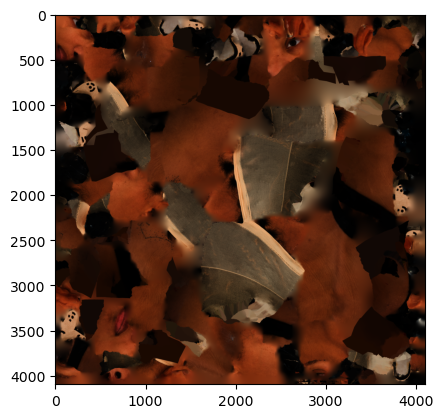

In [42]:
with torch.no_grad():
    material3 = Image.open("./scan_mesh_working/03_Neutral_00_new.png")
    m3 = torchvision.transforms.functional.to_tensor(material3)
    m3 = torch.permute(m3,(1,2,0)).unsqueeze(0).cuda()
    m3 = srgb_to_linear(m3)
plt.imshow(m3[0].cpu().detach())

# with torch.no_grad():
#     m4 = torch.rand([1,2048,2048,3],requires_grad=True).cuda()
#     m4[:] = (m4+1)/2

# m4.requires_grad=True
# m4.register_hook(lambda grad:100*grad)
# plt.imshow(m3[0].cpu().detach())


/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


torch.Size([82107, 3])


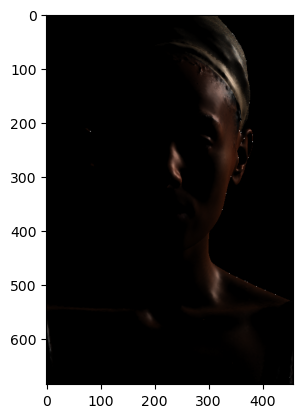

In [43]:
plt.figure()
#print(bump_map[:,1:10,1:10,:])
with torch.no_grad():
    t,norm,_ = render_PBR(mesh,cam2,m3,ray_d,reflectence=reflectence_scan, roughness= roughness_scan, bump_map= bump_map_scan,shadows=False)
    t0 = torch.clamp(t[4],0.,1.)
    t0 = t0.cpu().detach().numpy()
    a = t0[t0>0]
    b = a[a<1]
    #print(im_target.shape,t.shape,b,np.max(t0[:]),t0.shape)
    plt.imshow(t0)
print(mesh.vertex_normals.shape)


In [58]:
def disp_tile(tiles, title="Title"):
    my = len(tiles)
    mx = len(tiles[0])
    f, axes = plt.subplots(my,mx,figsize=(4 * 2*my, 4. * 2*mx))
    for y in range(my):
        for x in range(mx):
            axes[y,x].imshow(tiles[y][x])

    

In [59]:
def get_image_tile(im_target,x,y,maxtilex,maxtiley):
    n,h,w,c = im_target.shape
    tileh = h//maxtiley
    tilew = w//maxtilex
    startx = tilew*x
    endx = tilew*(x+1)
    starty = tileh*y
    endy = tileh*(y+1)
    return im_target[:,starty:endy,startx:endx,:]

In [60]:
def disp_stiched(tiles,title="Hello"):
    for y in range(len(tiles)):
        tiles[y] = np.concatenate(tiles[y],axis=1)
    im = np.concatenate(tiles,axis=0)
    f,axes = plt.subplots(1,1,figsize=(4 * 2, 4. * 2))
    print(im.shape)
    axes.imshow(im)

/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(2736, 1824, 3)


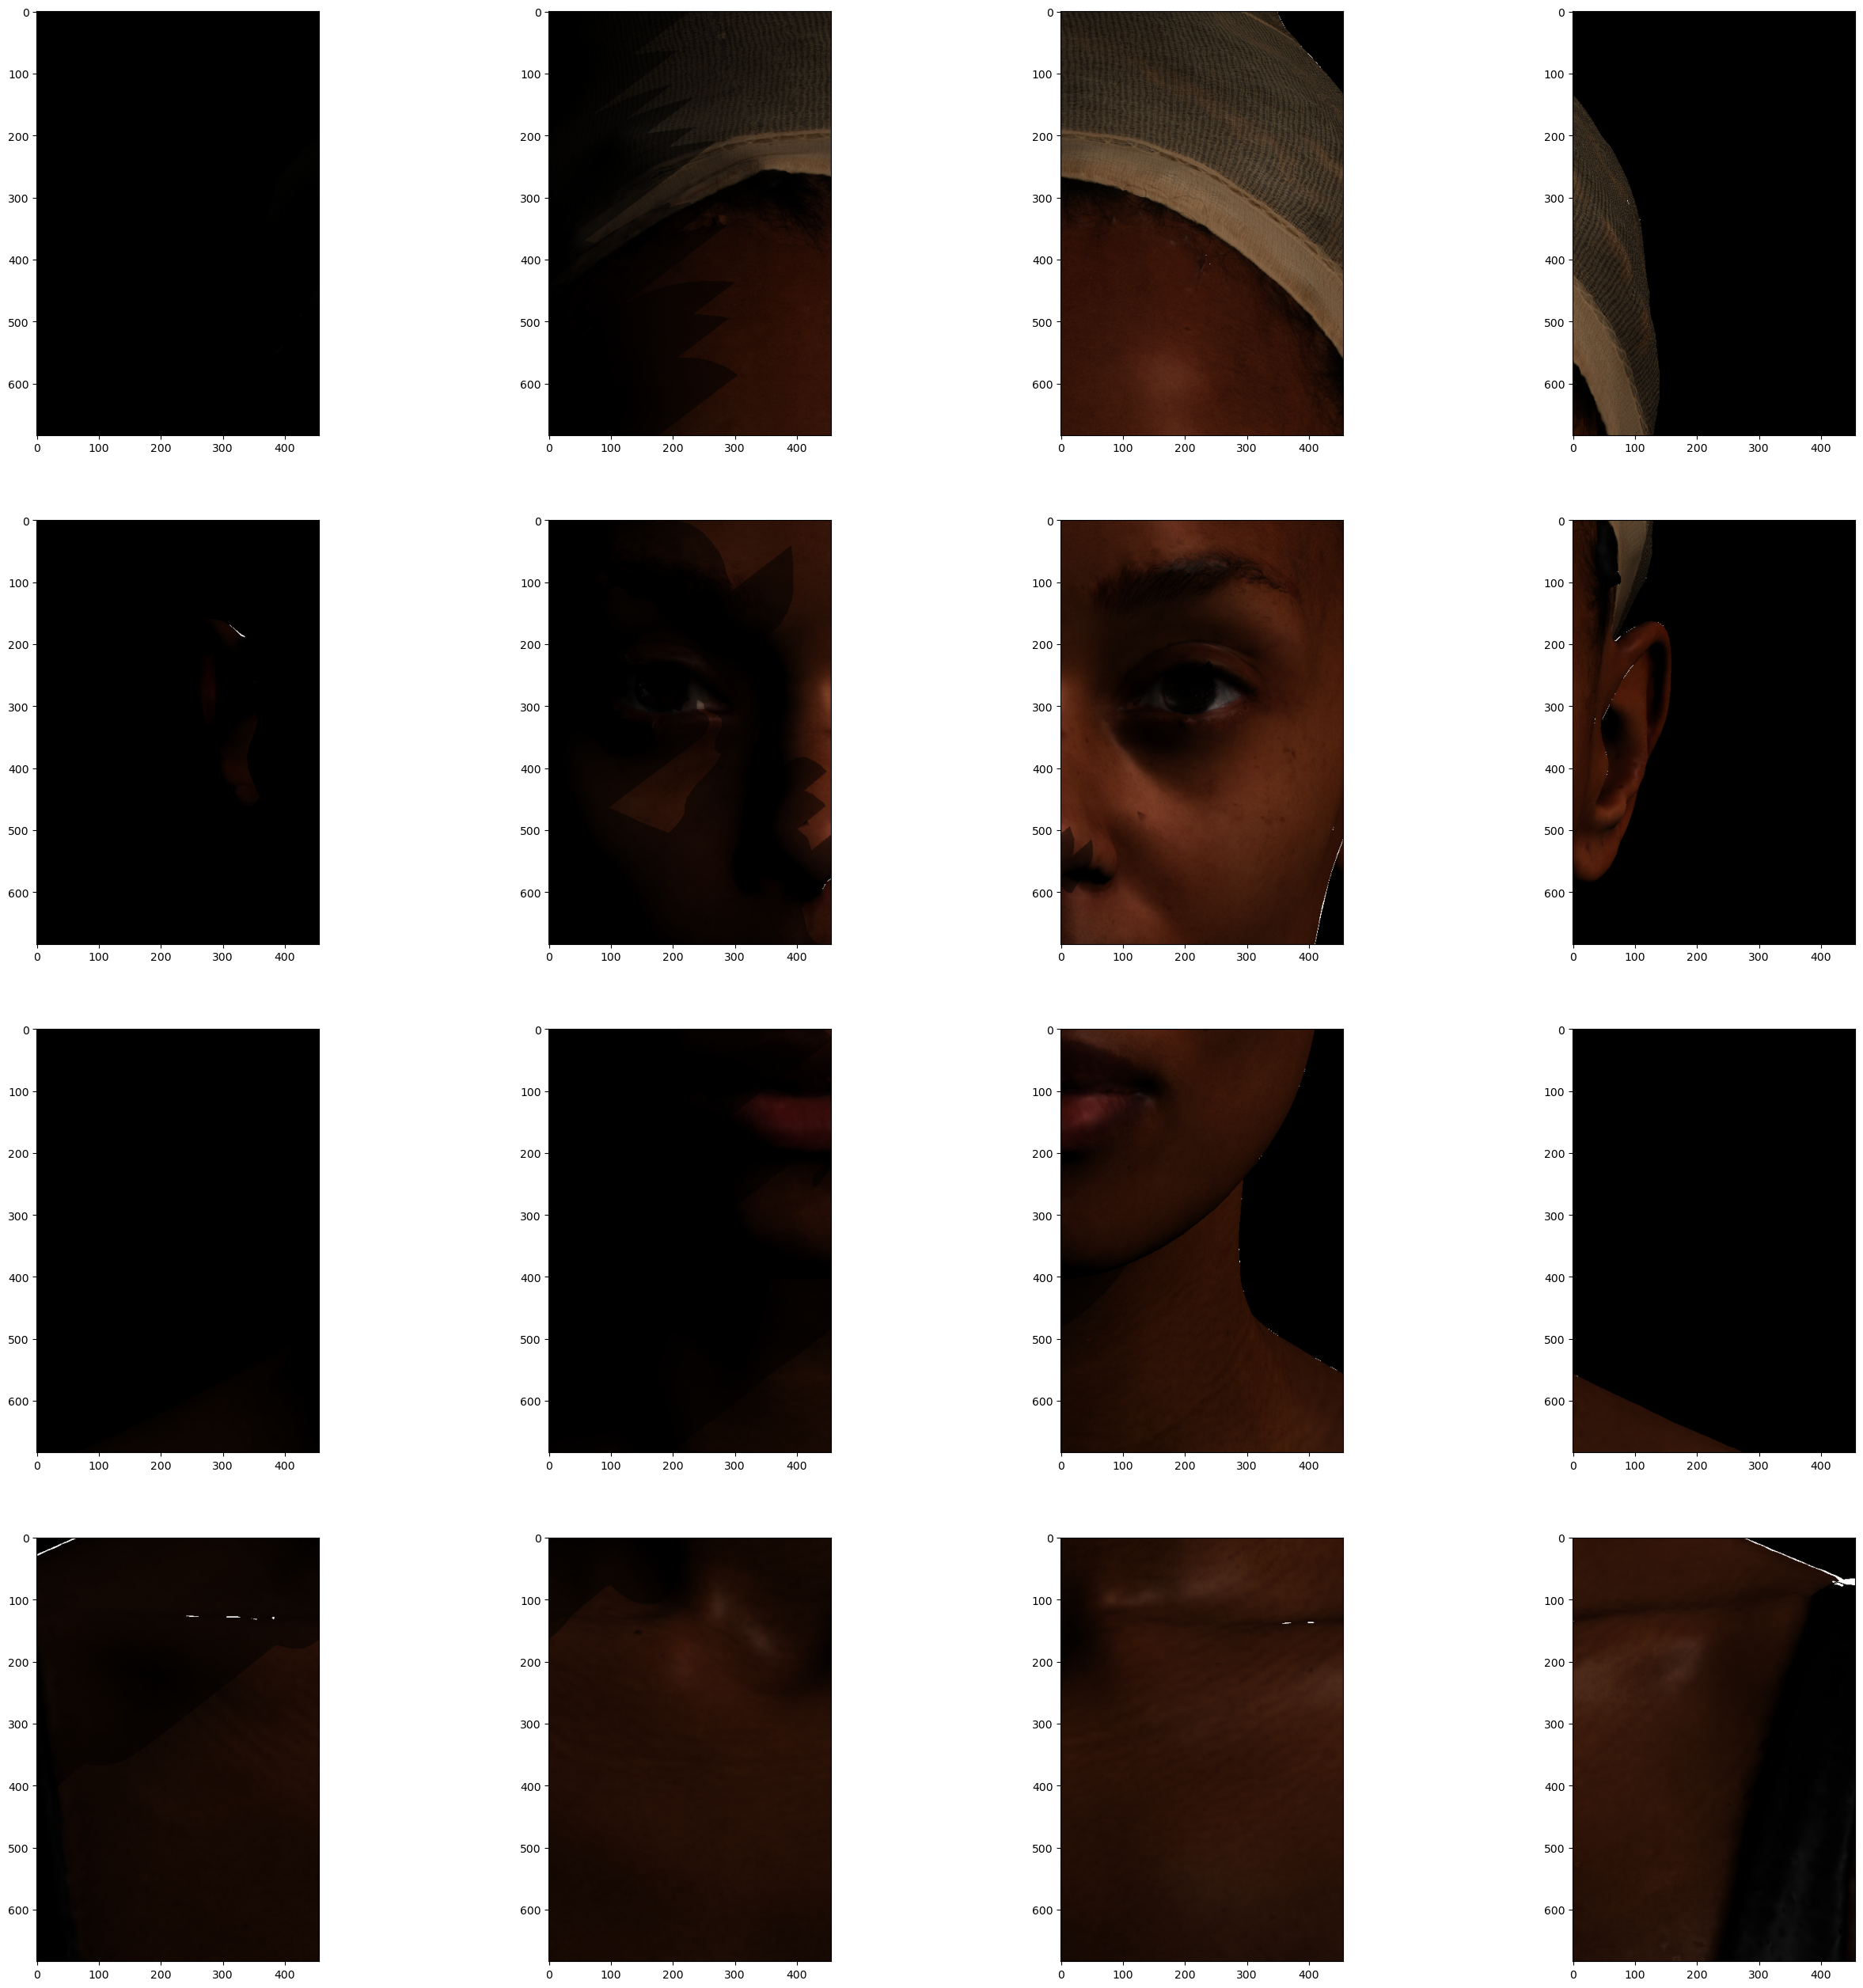

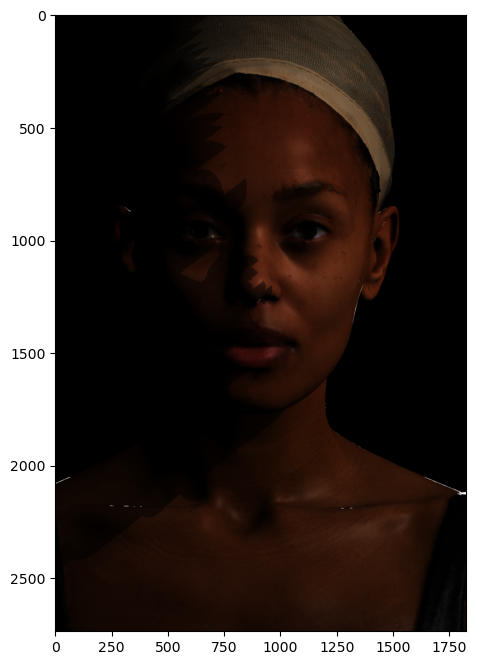

In [35]:

im=[[0 for i in range(maxtilex)] for j in range(maxtiley)]
with torch.no_grad():
    for x in range(maxtilex):
        for y in range(maxtiley):
            
            t,norm,_ = render_PBR(mesh,cam2,m3,ray_d,reflectence=reflectence_scan, roughness= roughness_scan, bump_map= bump_map_scan,shadows=True,tilex=x,tiley=y,maxtilex=maxtilex,maxtiley=maxtiley)
            im[y][x] = t[2].detach().cpu()
            #im[y][x] = get_image_tile(im_target2,x,y,maxtilex,maxtiley).detach().cpu()[0]#
disp_tile(im)
disp_stiched(im)
        

In [61]:
bump_map.register_hook(lambda grad: 10*grad)
reflectence.register_hook(lambda grad: 100*grad)
roughness.register_hook(lambda grad: 100*grad)
F0.register_hook(lambda grad: grad)
optim = torch.optim.SGD([materials], lr = 1., momentum = 0.8)
opt_rough = torch.optim.SGD([roughness], lr = 3., momentum = 0.2)
optim2 = torch.optim.Adam([source,amplitude],lr=0.3)
optim_bump_map = torch.optim.SGD([bump_map],lr=1.0,momentum=0.3)
optim_reflectence = torch.optim.SGD([reflectence],lr=1.0,momentum=0.3)
optim_shadow = torch.optim.SGD([shadow_fac],lr = 1.0)
optim_F0 = torch.optim.SGD([materials], lr = 0.3, momentum = 0.8)
#optim2 = torch.optim.Adam([source,amplitude],lr=1.)Actually there is a version of the glossy texture, but it is compatible with the OpenPBR shader model that I have implemented to calculate the Fresnel. I will see what I can do for that. 

#init_optim = torch.optim.SGD([m4],lr=1., momentum=0.3)
blur = torchvision.transforms.GaussianBlur(21, sigma=20.)
b = torch.transpose(blur.forward(torch.transpose(materials,0,3).squeeze(-1)).unsqueeze(-1),0,3)
print(b.shape)


torch.Size([1, 1024, 1024, 3])


In [62]:
bump_map_scan.register_hook(lambda grad: 100*grad)
reflectence_scan.register_hook(lambda grad: 300*grad)
roughness_scan.register_hook(lambda grad: 300*grad)

opt_rough_scan = torch.optim.SGD([roughness_scan], lr = 1., momentum = 0.2)

optim_bump_map_scan = torch.optim.SGD([bump_map_scan],lr=1.,momentum=0.5)
optim_reflectence_scan = torch.optim.SGD([reflectence_scan],lr=1.0,momentum=0.3)
#optim2 = torch.optim.Adam([source,amplitude],lr=1.)Actually there is a version of the glossy texture, but it is compatible with the OpenPBR shader model that I have implemented to calculate the Fresnel. I will see what I can do for that. 



In [63]:
def disp_imgs(imgs,target,title=None):
    """scatter images plotting"""
    n = max(imgs.shape[0],target.shape[0])

    f, axes = plt.subplots(2,n,figsize=(4 * 2, 4. * 2))
    f.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0., hspace=0.1)
    for i in range(n):
        if imgs.shape[0]>i:
            axes[0, i].imshow(imgs[i].cpu().detach())
            axes[0, i].set_xticks([])
        if target.shape[0]>i:
            axes[1, i].imshow(target[i].cpu().detach())
            axes[1, i].set_xticks([])
    

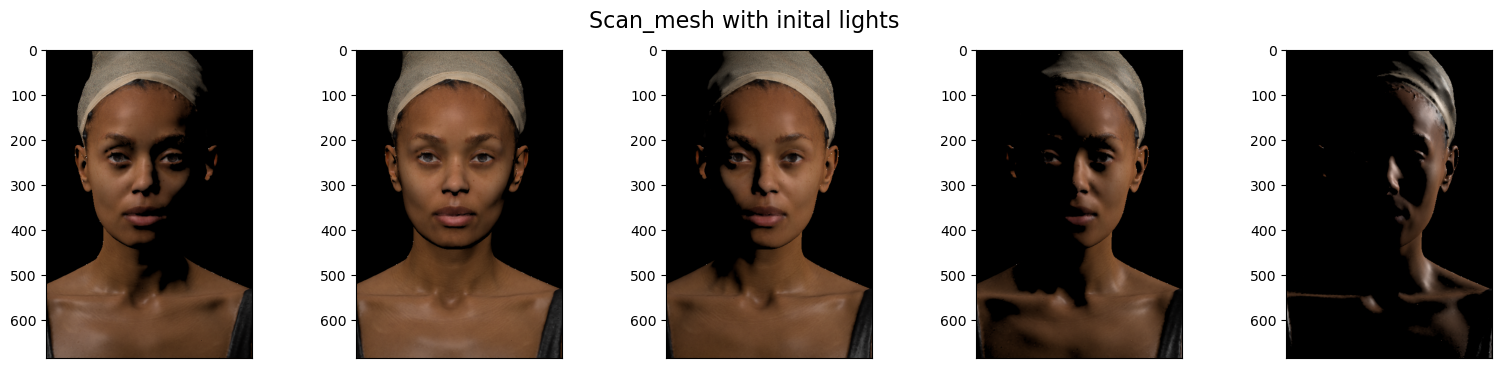

In [39]:
with torch.no_grad():
    r,_ ,_= render_PBR(mesh,cam2,m3,ray_d,reflectence=reflectence_scan, bump_map=bump_map_scan, roughness= roughness_scan,)
    #disp_imgs(torch.pow(r,1),im_target)#im_target)
    disp_target(torch.clamp(linear_to_srgb(r),0.,1.), title="Scan_mesh with inital lights")

In [40]:
with torch.no_grad():
    r,_ = render_PBR(game_mesh,cam2,torch.pow(game_diffuse,1.0),ray_d,bump_map=game_normal, roughness=game_roughness, reflectence = torch.zeros_like(game_F0)*0.0,shadows=True,F0=game_F0)
    disp_imgs(torch.pow(r,1),im_target)

NameError: name 'game_diffuse' is not defined

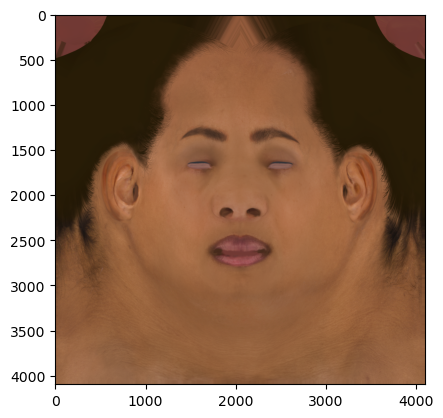

In [ ]:
plt.imshow(game_diffuse[0].cpu().detach())

In [39]:
loss_arr = []
iter_arr = []

In [40]:

for i in range(2000):
    with torch.no_grad():
        roughness_scan[:] = torch.clamp(roughness_scan,0.,0.98)
        # amplitude[torch.isnan(amplitude)] = 20
        # source[torch.isnan(source)] = torch.rand(source[torch.isnan(source)].shape).cuda()
        bump_map_scan[:] = torch.clamp(bump_map_scan,0.,1.)
        if i%50==0 and i<400:
            bump_map_scan[:] = torch.transpose(blur.forward(torch.transpose(torch.clamp(bump_map,0.,1.),0,3).squeeze(-1)).unsqueeze(-1),0,3)
        reflectence_scan[:] = torch.clamp(reflectence_scan,0.,1.)
        #pass
            
    optim2.zero_grad()
    opt_rough_scan.zero_grad()
    optim_bump_map_scan.zero_grad()
    optim_reflectence_scan.zero_grad()
    
    rendered, diff = render_PBR(mesh,cam2,m3,ray_d,roughness=roughness_scan,bump_map = bump_map_scan,reflectence=reflectence_scan)
    
    loss = 100*torch.nn.functional.mse_loss(rendered,srgb_to_linear(im_target))+0.1*torch.sum(torch.std(amplitude))#+torch.nn.functional.mse_loss(torch.norm(rendered,dim=-1),torch.norm(im_target/255,dim=-1))

    loss.backward()
    #roughness.retain_grad()
    amplitude.retain_grad()
    source.retain_grad()
    bump_map_scan.retain_grad()
    roughness_scan.retain_grad()
    reflectence_scan.retain_grad()
    optim2.step()
    opt_rough_scan.step()
    optim_reflectence_scan.step()
    
    if i>50:
        optim_bump_map_scan.step()
    if i%30==0:
        print("Loss:",loss.item())
        #print("roughness_grad",roughness.grad)
        loss_arr.append(loss.item())
        iter_arr.append(i)
        try:
            print(torch.max(bump_map_scan.grad).data)
            print(torch.max(roughness_scan.grad).data)
            print(torch.max(reflectence_scan.grad).data)
        except:
            continue
        
        
print(source.grad,source)


    


Loss: 0.24202722311019897
tensor(0.0541, device='cuda:0')
tensor(0.0167, device='cuda:0')
tensor(0.0169, device='cuda:0')
Loss: 0.19265638291835785
tensor(0.0455, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0166, device='cuda:0')
Loss: 0.17397567629814148
tensor(0.0034, device='cuda:0')
tensor(0.0050, device='cuda:0')
tensor(0.0087, device='cuda:0')
Loss: 0.15630686283111572
tensor(0.0094, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0093, device='cuda:0')
Loss: 0.15835364162921906
tensor(0.0029, device='cuda:0')
tensor(0.0028, device='cuda:0')
tensor(0.0061, device='cuda:0')
Loss: 0.17959828674793243
tensor(0.0236, device='cuda:0')
tensor(0.0144, device='cuda:0')
tensor(0.0159, device='cuda:0')
Loss: 0.14754851162433624
tensor(0.0020, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0062, device='cuda:0')
Loss: 0.15370459854602814
tensor(0.0052, device='cuda:0')
tensor(0.0045, device='cuda:0')
tensor(0.0063, device='cuda:0')
Loss: 0.1409913599491119

Max_loss: tensor(0.1582)


Text(0.5, 1.0, 'Light Optimisation loss plot')

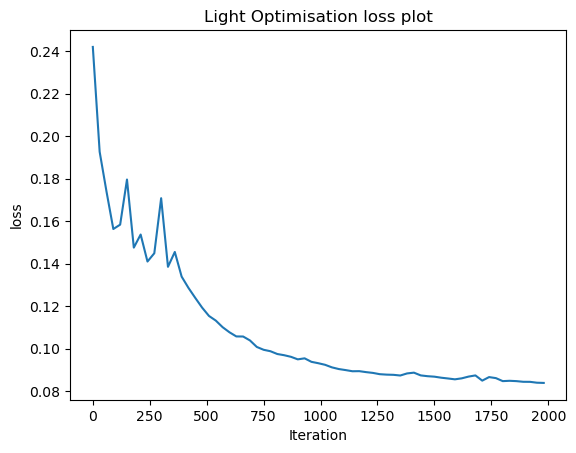

In [41]:
l = [l for l in loss_arr]
p = torch.tensor(l)
p_los = torch.abs(p-p[-1])
print("Max_loss:", torch.max(p_los[-100:]))
plt.plot(iter_arr,l)
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.title("Light Optimisation loss plot")

tensor(0.9813, device='cuda:0') tensor(0.5000, device='cuda:0')
tensor(1., device='cuda:0')
tensor([[[200.5143, 200.5142, 200.5055]],

        [[200.5142, 200.5143, 200.5174]],

        [[200.5135, 200.5140, 200.5141]],

        [[200.5142, 200.5142, 200.5144]],

        [[200.5029, 200.5565, 200.5033]]], device='cuda:0', requires_grad=True) tensor([[[-5.8239,  7.5765,  1.5765]],

        [[-0.6525,  6.9250,  5.1808]],

        [[ 6.7952,  5.4044,  3.4615]],

        [[ 8.3826,  5.1006, -2.2559]],

        [[ 7.1495,  3.0243, -7.2594]]], device='cuda:0', requires_grad=True)


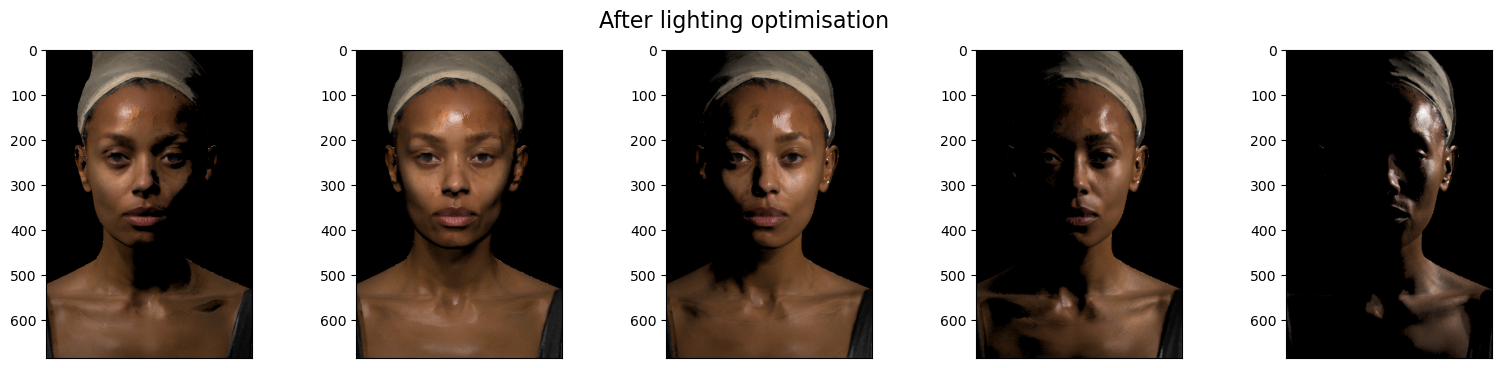

In [42]:
with torch.no_grad():
    rendered,diff = render_PBR(mesh,cam2,m3,ray_d,roughness=roughness_scan,bump_map = bump_map_scan,reflectence=reflectence_scan)
    disp_target(torch.clamp(linear_to_srgb(rendered),0.,1.), "After lighting optimisation")
    print(torch.max(roughness_scan[:]),torch.min(roughness[:]))
    print(torch.max(bump_map))
    print(amplitude, source)

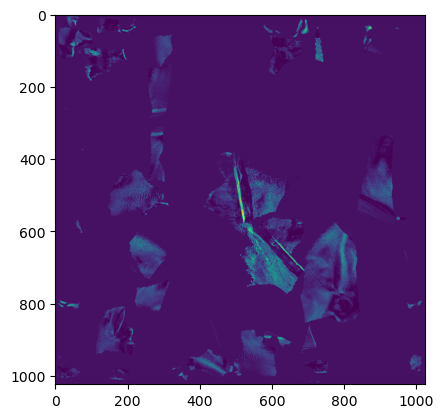

In [44]:
plt.imshow(roughness_scan[0].detach().cpu())
#plt.imshow(bump_map_scan[0].detach().cpu())
plt.imshow(reflectence_scan[0].detach().cpu())

/home/bhartrhari/miniconda3/envs/kaolin_nv/lib/python3.11/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 684, 456, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].


tensor(1., device='cuda:0')


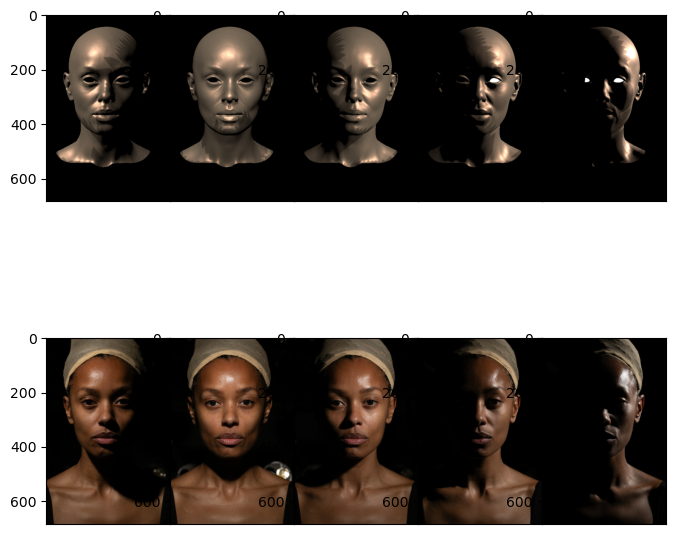

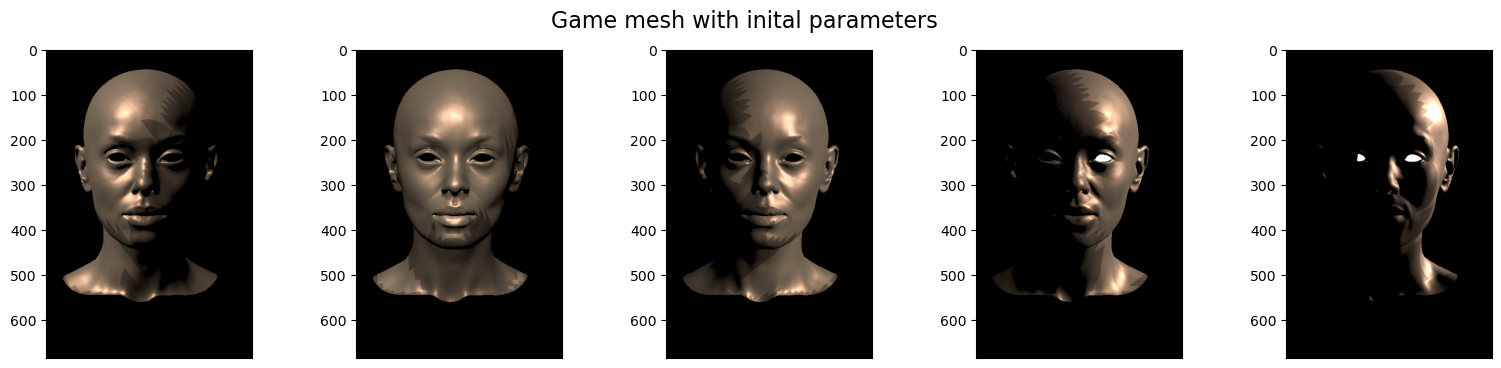

In [64]:
loss_arr_im =[]
iter_arr_im = []
with torch.no_grad():
    r,shadows,_ = render_PBR(game_mesh,cam2,materials,ray_d,bump_map= torch.clamp(bump_map,0.,1.), reflectence = torch.clamp(reflectence,0.,1.),roughness=roughness.clamp(0.,1.), shadows=True, F0=F0)
    print(shadows.shape)
    disp_imgs(linear_to_srgb(r).clamp(0.,1.),torch.pow(im_target,1))
    print(torch.max(im_target))
    disp_target(linear_to_srgb(r),title="Game mesh with inital parameters")

In [65]:
blur2 = torchvision.transforms.GaussianBlur(101, sigma=100.)

samples = np.array([i for i in range(maxtiley*maxtiley)])
loss_sample = np.array([1. for i in range(maxtiley*maxtiley)])

In [66]:
for i in range(1000):
    # optim.zero_grad()
    # optim2.zero_grad()
    # opt_rough.zero_grad()
    # optim_bump_map.zero_grad()
    # optim_reflectence.zero_grad()
    # optim_shadow.zero_grad()
    # optim_F0.zero_grad()
    with torch.no_grad():
        if i%100==1 and i<200:
            pass
            materials[:] = torch.transpose(blur.forward(torch.transpose(torch.clamp(materials,0.,1.),0,3).squeeze(-1)).unsqueeze(-1),0,3)
            
            #bump_map[:] = torch.transpose(blur.forward(torch.transpose(torch.clamp(bump_map,0.,1.),0,3).squeeze(-1)).unsqueeze(-1),0,3)
            #materials[:] = torch.permute(torchvision.transforms.functional.adjust_brightness(torch.permute(materials,(0,3,1,2)),0.6),(0,2,3,1))

        roughness[:] = torch.clamp(roughness,0.,1.)
        reflectence[:] = torch.clamp(reflectence,0.,1.)
        bump_map[:] = torch.clamp(bump_map,0.,1.)
        
    
    
    for xy in range(1):
        
        optim.zero_grad()
        optim2.zero_grad()
        opt_rough.zero_grad()
        optim_bump_map.zero_grad()
        optim_reflectence.zero_grad()
        optim_shadow.zero_grad()
        optim_F0.zero_grad()

        loss = 0
        with torch.no_grad():
            roughness[:] = torch.clamp(roughness,0.,1.)
            reflectence[:] = torch.clamp(reflectence,0.,1.)
            bump_map[:] = torch.clamp(bump_map,0.,1.)
            F0[:] = torch.clamp(F0,0.,1.)
        # p_samp = loss_sample/np.sum(loss_sample)
        # xy= np.random.choice(samples,replace=True, p=p_samp)
        x_rand = int(xy%maxtilex)
        y_rand = int(xy//maxtilex)
        materials2 = torch.clamp(materials,0.,1.)
        rendered, hard,_ = render_PBR(game_mesh,cam2,materials2,ray_d,roughness=roughness,bump_map=bump_map,reflectence=reflectence,shadows=False,F0=F0)#maxtilex=maxtilex,maxtiley=maxtiley,tilex=x_rand,tiley=y_rand)
        

        #im_tile = get_image_tile(im_target2,x_rand,y_rand, maxtilex,maxtiley)
        #im_lum = get_image_tile(weights_loss,x_rand,y_rand, maxtilex,maxtiley)
        mask = hard.repeat(weights_loss.shape[0],1,1,1)

        if i%800<=200:
            n = torch.norm((rendered-hard*srgb_to_linear(im_target)),dim=-1).unsqueeze(-1)
            n = n**2*weights_loss
            loss += 100*torch.mean(n[mask])/torch.mean(weights_loss)#+TV/10**6
            loss_sample[xy] = max(0.01,100*torch.mean(n))
        else:
            n = torch.norm(rendered-hard*srgb_to_linear(im_target),dim=-1).unsqueeze(-1)
            n = n**2
            loss += 100*torch.mean(n[mask])
            loss_sample[xy] = max(0.01,100*torch.mean(n))

        loss.backward()

        loss.retain_grad()
        bump_map.retain_grad()
        roughness.retain_grad()

        if i%800<=200:
            optim.step()
        else:
            opt_rough.step()
            optim_reflectence.step()
            optim_F0.step()
        if i>50:
            
            optim_bump_map.step()

        #optim_shadow.step()
        #optim2.step()
        
    #loss = torch.mean(loss, dim=[1,2,3])
    #print(loss.shape)
    #loss = torch.sum(loss)
    
    
    # loss.backward()

    # loss.retain_grad()
    # bump_map.retain_grad()
    # roughness.retain_grad()
    
    
    
    # opt_rough.step()
    # optim_reflectence.step()
    # optim_F0.step()
    # if i%600<=200:
    #     optim.step()
    # else:
    #     opt_rough.step()
    #     optim_reflectence.step()
    #     optim_F0.step()
    # if i>50:
        
    #     optim_bump_map.step()
    
    # optim_shadow.step()
    #optim2.step()
    if i%5==0:
        save_image(torch.permute(linear_to_srgb(materials2[0]),(2,0,1)),f"./animation/frame_{i}.png")
    if i%10==0:
        print("Iter:",i)
        print("Loss:",loss)
        #print(torch.mean(roughness[roughness<0]))
        print(torch.max(bump_map.grad).data)
        print(torch.max(roughness.grad).data)
        #print(torch.max(reflectence.grad).data)
        print(torch.max(materials.grad).data)
        loss_arr_im.append(loss.item())
        if len(iter_arr_im)>0:
            iter_arr_im.append(iter_arr_im[-1]+10)
        else:
            iter_arr_im.append(i)
        #print("TV:",torch.sum(TV)/10**5)
        #print(max(roughness.grad[:]))
        #print("amplitude:",sharpness)
print(loss_sample)

Iter: 0
Loss: tensor(7.7008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1672, device='cuda:0')
tensor(0.1173, device='cuda:0')
tensor(0.9718, device='cuda:0')
Iter: 10
Loss: tensor(1.7467, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1036, device='cuda:0')
tensor(0.0122, device='cuda:0')
tensor(0.7519, device='cuda:0')
Iter: 20
Loss: tensor(1.2424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0519, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.7730, device='cuda:0')
Iter: 30
Loss: tensor(1.1121, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0767, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.5052, device='cuda:0')
Iter: 40
Loss: tensor(1.0659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0303, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.6208, device='cuda:0')
Iter: 50
Loss: tensor(1.0465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0791, device='cuda:0')
tensor(0.0118, device='cuda:0')
tensor(0.5468, device='cuda:0')

In [67]:
import re
files = glob.glob(f"./animation/frame_*.png")
key=lambda s: int(s.split("_")[1].split(".")[0])
files = sorted(files,key=key)
print(files)

['./animation/frame_0.png', './animation/frame_5.png', './animation/frame_10.png', './animation/frame_15.png', './animation/frame_20.png', './animation/frame_25.png', './animation/frame_30.png', './animation/frame_35.png', './animation/frame_40.png', './animation/frame_45.png', './animation/frame_50.png', './animation/frame_55.png', './animation/frame_60.png', './animation/frame_65.png', './animation/frame_70.png', './animation/frame_75.png', './animation/frame_80.png', './animation/frame_85.png', './animation/frame_90.png', './animation/frame_95.png', './animation/frame_100.png', './animation/frame_105.png', './animation/frame_110.png', './animation/frame_115.png', './animation/frame_120.png', './animation/frame_125.png', './animation/frame_130.png', './animation/frame_135.png', './animation/frame_140.png', './animation/frame_145.png', './animation/frame_150.png', './animation/frame_155.png', './animation/frame_160.png', './animation/frame_165.png', './animation/frame_170.png', './ani

In [68]:
img, *imgs = [Image.open(f) for f in files]

img.save(
    fp="./animation.gif",
    append_images=imgs,
    save_all=True,
    duration=200,
    loop=0
)

In [54]:
print(files)

['./animation/frame_0.png', './animation/frame_10.png', './animation/frame_100.png', './animation/frame_105.png', './animation/frame_110.png', './animation/frame_115.png', './animation/frame_120.png', './animation/frame_125.png', './animation/frame_130.png', './animation/frame_135.png', './animation/frame_140.png', './animation/frame_145.png', './animation/frame_15.png', './animation/frame_150.png', './animation/frame_155.png', './animation/frame_160.png', './animation/frame_165.png', './animation/frame_170.png', './animation/frame_175.png', './animation/frame_180.png', './animation/frame_185.png', './animation/frame_190.png', './animation/frame_195.png', './animation/frame_20.png', './animation/frame_200.png', './animation/frame_205.png', './animation/frame_210.png', './animation/frame_215.png', './animation/frame_220.png', './animation/frame_225.png', './animation/frame_230.png', './animation/frame_235.png', './animation/frame_240.png', './animation/frame_245.png', './animation/frame

torch.Size([1, 684, 456, 1])
tensor(1., device='cuda:0')


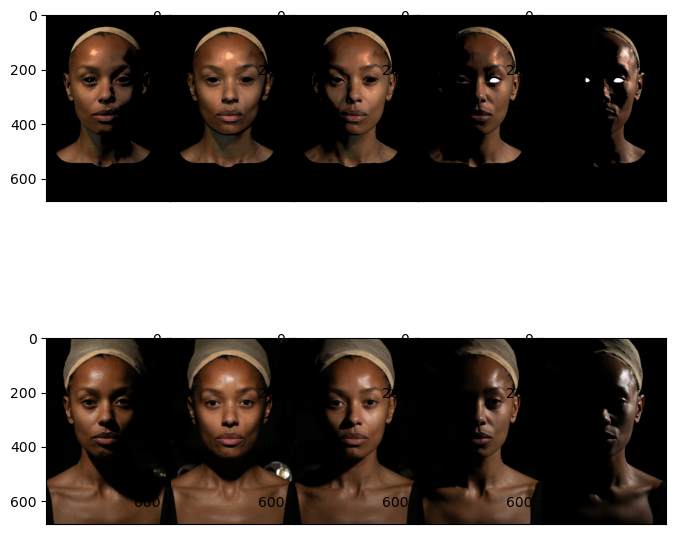

In [69]:
with torch.no_grad():
    r,shadows,_ = render_PBR(game_mesh,cam2,materials2,ray_d,bump_map= torch.clamp(bump_map,0.,1.), reflectence = torch.clamp(reflectence,0.,1.),roughness=roughness.clamp(0.,1.), shadows=False,F0=F0)
    print(shadows.shape)
    disp_imgs(linear_to_srgb(r).clamp(0.,1.),torch.pow(im_target,1))
    print(torch.max(im_target))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000004].


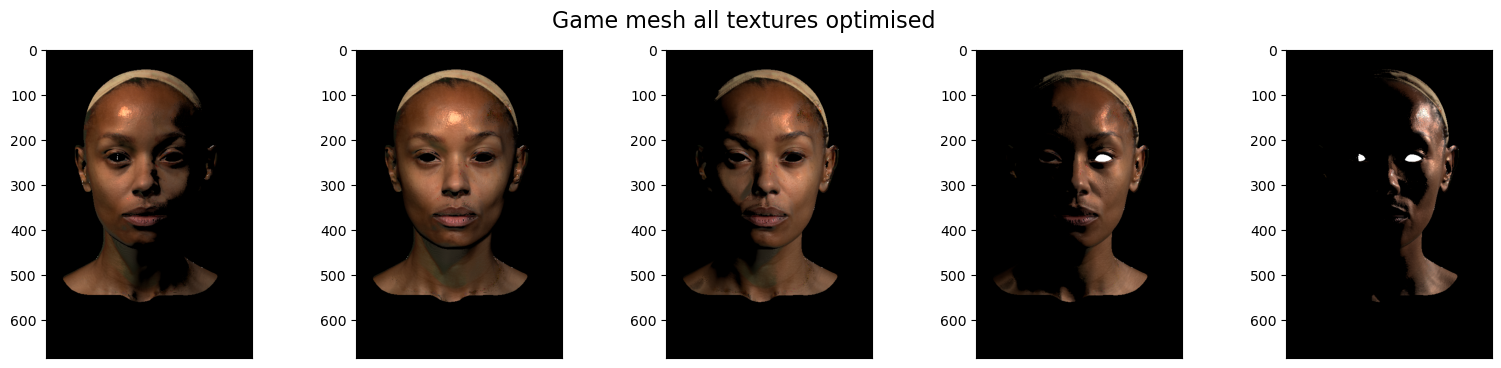

In [70]:
disp_target(linear_to_srgb(r),title="Game mesh all textures optimised")

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')
0.3185102045536041


/tmp/ipykernel_364574/1119680552.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.abs((torch.tensor(p)-p[-1])[-100:]))


Text(0.5, 1.0, 'Loss inverse texturing problem')

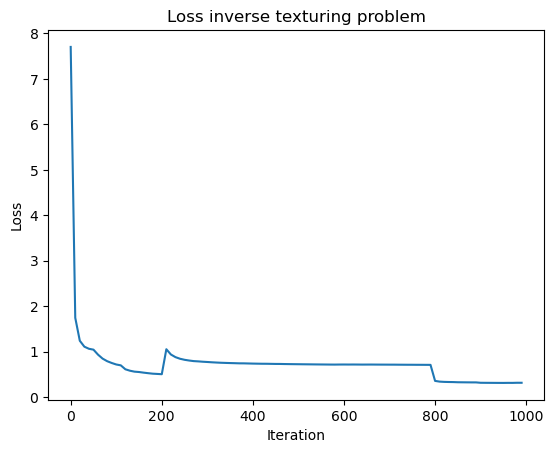

In [71]:
plt.plot(iter_arr_im, loss_arr_im)

print(torch.abs((torch.tensor(p)-p[-1])[-100:]))
print(loss_arr_im[-1])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss inverse texturing problem")

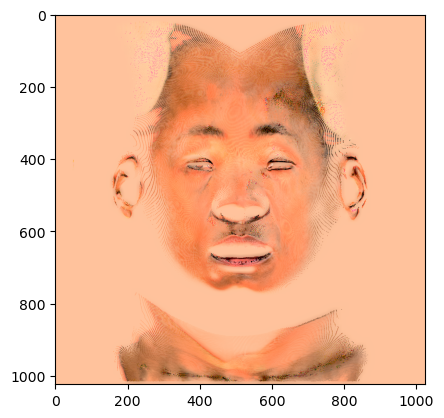

In [72]:

plt.imshow(torch.clamp(linear_to_srgb(materials[0]),0.,1.).detach().cpu().numpy())


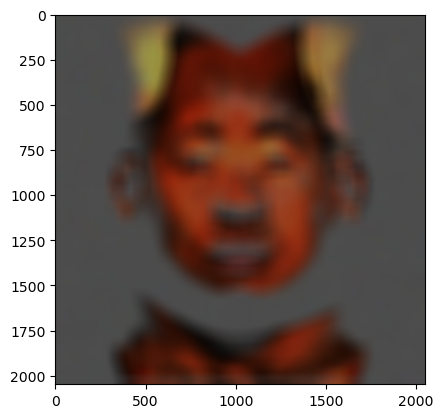

In [44]:
blur2 = torchvision.transforms.GaussianBlur(101, sigma=100.)
material3 = torch.transpose(blur2.forward(torch.transpose(torch.clamp(materials,0.,1.),0,3).squeeze(-1)).unsqueeze(-1),0,3)
material3 =  torch.permute(torchvision.transforms.functional.adjust_brightness(torch.permute(material3,(0,3,1,2)),0.6),(0,2,3,1))
plt.imshow(torch.clamp(material3[0],0.,1.).detach().cpu().numpy())

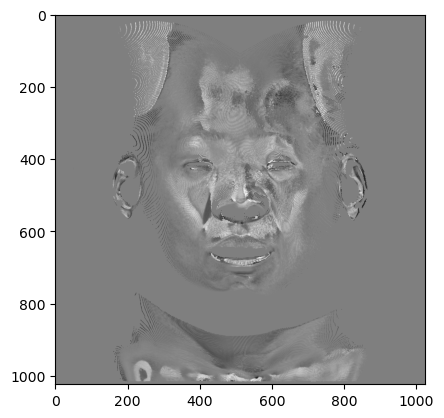

In [55]:
plt.imshow(roughness[0].repeat((1,1,3)).detach().cpu().numpy())
r = roughness[0].repeat((1,1,3)).detach().cpu()
save_image(linear_to_srgb(torch.permute(r,(2,0,1)).clamp(0,1).float()),"roughness.png")

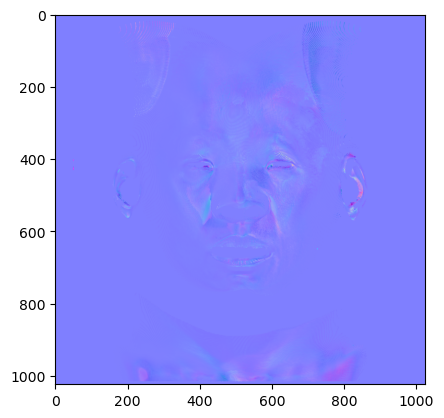

In [56]:
b = bump_map[0].detach().cpu()
plt.imshow((bump_map[0].clamp(0.,1.)).detach().cpu().numpy())

b = torch.permute(b,(2,0,1))
save_image(linear_to_srgb(b.clamp(0,1.)),"normals_ai(8).png")


torch.Size([1, 1024, 1024, 3])


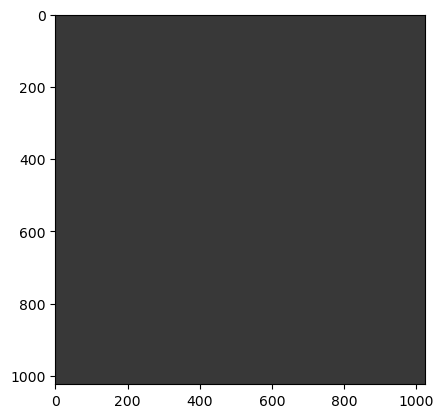

In [57]:
f = F0.detach().cpu()
plt.imshow(linear_to_srgb(f[0]))
f = linear_to_srgb(f)
print(f.shape)
f = torch.permute(f[0],(2,0,1))

save_image(f,"specular_albedo.png")

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1024, 1024, 3])


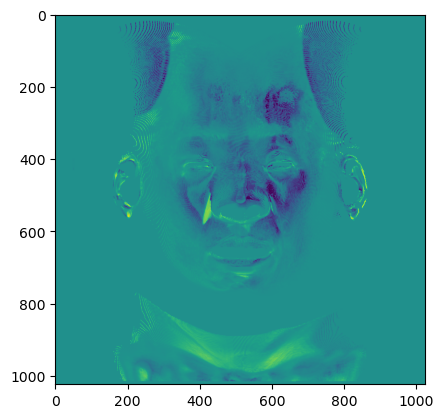

In [58]:

print(torch.max(reflectence))
ref = torch.clamp(reflectence[0],0.,1.).detach().cpu()
f0 = torch.lerp(torch.tensor([0.04]), materials2.cpu().detach()[0], ref)
plt.imshow(ref)
print(f0.shape)
f0 = torch.permute(f0,(2,0,1))

save_image(linear_to_srgb(torch.permute(ref,(2,0,1))),"metallic_factor.png")

In [57]:
print(materials.shape)
s = torch.transpose(torch.clamp(materials,0.,1.).detach().cpu(),0,3)
with torch.no_grad():
    s = s.squeeze(-1)
    s2 = linear_to_srgb(s)
    

    save_image(s2.clamp(0,1), "text_new_meth(9).png")
    

torch.Size([1, 1024, 1024, 3])


In [61]:
torch.save([amplitude,source],"lighting_param.pt")

In [58]:
s = torch.transpose(bump_map.detach().cpu(),0,3)

with torch.no_grad():
    s = s.squeeze(-1)
    #s = (s+1)/2
    s = s
    save_image(s, "normals_ai(8).png")

   

In [59]:
s = roughness

In [155]:
def shadow_mask(mesh,light)

SyntaxError: expected ':' (366104641.py, line 1)

In [1]:
class Light():
    def __init__(self,pos,amp,res=500):
        self.pos = pos
        self.amp=amp
        self.views=[]
        self.rast=[]
        self.res = res
    def gen_views(self):
        v = [0,0,0]
        for i in range(3):
            v=[0.,0.,0.]
            v[i]=1.
            cam1 = kal.render.camera.Camera.from_args(eye=self.pos, at=v,up=[0.,1.,0.],fov = torch.pi/2,width=self.res,height=self.res)
            v[i]=-1.
            cam2 = kal.render.camera.Camera.from_args(eye=self.pos, at=v,up=[0.,1.,0.],fov = torch.pi/2,width=self.res,height=self.res)
            self.views.append(cam1)
            self.views.append(cam2)
    def raster(self,mesh):
        

SyntaxError: incomplete input (208254134.py, line 18)

In [ ]:
def render(mesh, cam, materials, rays_d,azimuth=azimuth,elevation=elevation,amplitude=amplitude,sharpness=sharpness,roughness=roughness,bump_map=bump_map):
    """
    proj_mat = kal.render.camera.generate_perspective_projection(cam.fov())
    transform = kal.render.camera.generate_transformation_matrix(cam.position,cam.at,cam.up)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(in_batch_size, 1, 1),
            mesh.faces, proj_mat, camera_transform=transform)
    return True
    
    """
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)

    #kaolin.render.mesh.dibr_rasterization(height, width, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='cuda')¶
    
    rast = nvdiffrast.torch.rasterize(
        nvctx, vertices_clip, mesh.faces.int(),
        (cam.height, cam.width), grad_db=True
    )
    rast0 = torch.flip(rast[0], dims=(1,)).contiguous()

    
    
    h = rast0[:, :, :, -1:]
    #return h
    #return (rast0[rast0[:, :, :, -1:] != 0.)
    hard_mask = rast0[:, :, :, -1:] != 0
    
    face_idx = (rast0[..., -1].long() - 1).contiguous()

    uv_map = nvdiffrast.torch.interpolate(
        mesh.uvs, rast0, mesh.face_uvs_idx.int()
    )[0] % 1.
    uv_map = uv_map.contiguous()

    normals = nvdiffrast.torch.interpolate(
        mesh.vertex_normals, rast0, mesh.face_uvs_idx.int()
    )[0]

    
    # Obj meshes can be composed of multiple materials
    # so at rendering we need to interpolate from corresponding materials
    im_material_idx = mesh.material_assignments[face_idx]  # Assume single assignments map
    im_material_idx[face_idx == -1] = -1

    pixel_val = nvdiffrast.torch.texture(
                materials.contiguous(),
                uv_map,
                filter_mode='linear'
                )
    spec_albedo = nvdiffrast.torch.texture(
                    spec_texture.contiguous(),
                    uv_map,
                    filter_mode='linear'
                  )
    bm = nvdiffrast.torch.texture(
                    bump_map.contiguous(),
                    uv_map,
                    filter_mode='linear'
                  )
    r = nvdiffrast.torch.texture(
            roughness.contiguous(),
            uv_map,
            filter_mode="linear"
            )
    rough = torch.clamp(r,0.,1.)
    spec_albedo = torch.clamp(spec_albedo*hard_mask, 0., 1.)
    normals = bm+normals
    
    #pixel_val.retain_grad()
    #print("Pixel",(pixel_val.grad))
    pic = torch.clamp(pixel_val*hard_mask, 0., 1.)
    #res = nvdiffrast.torch.antialias(pic,rast[0],vertices_clip, mesh.faces.int(),pos_gradient_boost=2.0)
    res=pic

    #direction = torch.tensor([0.,1.,0.]).cuda().unsqueeze(0)
    #amplitude = torch.tensor([2.,2.,2.]).cuda().unsqueeze(0)

    #sharpness =torch.tensor([5.]).cuda()
    normals = normals#/(torch.norm(normals,dim =3, keepdim=True)+0.001)
    #direction = direction/torch.norm(direction)
    direction = torch.stack(kal.ops.coords.spherical2cartesian(azimuth, elevation), dim=-1)
    #amplitude = amplitude.repeat(1,1,3)
    #print(rough[hard_mask[:,:,:,0],:].shape,normals[hard_mask[:,:,:,0],:].shape)
    #print(amplitude)
    im = []
    for i in range(direction.shape[0]):
        #print(direction[i].shape,amplitude[i].unsqueeze(0).shape)
        diffuse = kal.render.lighting.sg_diffuse_fitted(amplitude[i], direction[i], sharpness[i], normals[hard_mask[:,:,:,0],:], res[hard_mask[:,:,:,0],:])
        res2 = 2*res.clone()*torch.sum(normals*direction[i],dim=-1, keepdim=True)*amplitude[i]/10
        #res2[hard_mask[:,:,:,0],:] += 1.*diffuse
        
        # specular_effect = kal.render.lighting.sg_warp_specular_term(
        #         amplitude[i],
        #         direction[i],
        #         sharpness[i],
        #         normals[hard_mask[:,:,:,0],:],
        #         rough[hard_mask[:,:,:,0],:].squeeze(-1),
        #         rays_d[hard_mask[:,:,:,0],:],
        #         spec_albedo[hard_mask[:,:,:,0],:]
        #     )
        #print(specular_effect.max())
        reflection = -direction[i]-2*torch.sum(normals*-direction[i],dim=-1, keepdim=True)*normals
        #print("torchnorm",torch.max(torch.norm(reflection,dim=-1)[:]))

        n = 64*torch.pow(torch.e,-(rough*rough))
        #print(n)
        specular_effect = spec_albedo*torch.pow(torch.clamp(torch.sum(reflection*rays_d,dim=-1,keepdim=True),0.,1.),n)*amplitude[i]/10
        
        
        #print(n*64)
        res2 += specular_effect
        #res2[hard_mask[:,:,:,0],:] += 0.05*torch.pow(specular_effect,16)
        im.append(res2)
    final_res = torch.stack(im,dim=1)
    return torch.clamp(final_res[0],0.,1.), normals

In [ ]:
def render(mesh, cam, materials, rays_d,source=source,amplitude=amplitude,roughness=roughness,bump_map=bump_map):
    """
    proj_mat = kal.render.camera.generate_perspective_projection(cam.fov())
    transform = kal.render.camera.generate_transformation_matrix(cam.position,cam.at,cam.up)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(in_batch_size, 1, 1),
            mesh.faces, proj_mat, camera_transform=transform)
    return True
    
    """
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)
    
    #kaolin.render.mesh.dibr_rasterization(height, width, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='cuda')¶
    
    rast = nvdiffrast.torch.rasterize(
        nvctx, vertices_clip, mesh.faces.int(),
        (cam.height, cam.width), grad_db=True
    )
    rast0 = torch.flip(rast[0], dims=(1,)).contiguous()

    
    
    h = rast0[:, :, :, -1:]
    #return h
    #return (rast0[rast0[:, :, :, -1:] != 0.)
    hard_mask = rast0[:, :, :, -1:] != 0
    
    face_idx = (rast0[..., -1].long() - 1).contiguous()

    uv_map = nvdiffrast.torch.interpolate(
        mesh.uvs, rast0, mesh.face_uvs_idx.int()
    )[0] % 1.
    uv_map = uv_map.contiguous()

    normals_s = nvdiffrast.torch.interpolate(
        mesh.vertex_normals, rast0, mesh.face_uvs_idx.int()
    )[0]
    tangent_vert = compute_tangents_vectorized(mesh.vertices,mesh.uvs,mesh.faces)
    tangent = nvdiffrast.torch.interpolate(
        tangent_vert, rast0, mesh.face_uvs_idx.int()
    )[0]

    dir,p = light(mesh.vertices, source, amplitude)
    
    
    
    # Obj meshes can be composed of multiple materials
    # so at rendering we need to interpolate from corresponding materials
    im_material_idx = mesh.material_assignments[face_idx]  # Assume single assignments map
    im_material_idx[face_idx == -1] = -1

    pixel_val = nvdiffrast.torch.texture(
                materials.contiguous(),
                uv_map,
                filter_mode='linear'
                )
    spec_albedo = nvdiffrast.torch.texture(
                    spec_texture.contiguous(),
                    uv_map,
                    filter_mode='linear'
                  )
    bm = nvdiffrast.torch.texture(
                    bump_map.contiguous(),
                    uv_map,
                    filter_mode='linear'
                  )
    
    rough = roughness
    spec_albedo = torch.clamp(spec_albedo*hard_mask, 0., 1.)
    bm = torch.clamp(bm*hard_mask,0.,1.)
    bm = (bm*2.)-1.
    bm = torch.nn.functional.normalize(bm,dim=-1)
    normals_s = torch.nn.functional.normalize(normals_s,dim=-1)
    tangent = torch.nn.functional.normalize(tangent,dim=-1)
    
    bitangent = torch.nn.functional.normalize(torch.cross(normals_s,tangent, dim = -1))

    



    TBN = torch.stack([tangent,bitangent,normals_s],dim=-1)
    normals = torch.nn.functional.normalize(torch.matmul(TBN,bm.unsqueeze(-1)).squeeze(-1),dim=-1)
    #print("Normals",normals.shape)
    
    #pixel_val.retain_grad()
    #print("Pixel",(pixel_val.grad))
    pic = torch.clamp(pixel_val*hard_mask, 0., 1.)
    #res = nvdiffrast.torch.antialias(pic,rast[0],vertices_clip, mesh.faces.int(),pos_gradient_boost=2.0)
    res=pic
    #print(res[res<0.0])
    #direction = torch.tensor([0.,1.,0.]).cuda().unsqueeze(0)
    #amplitude = torch.tensor([2.,2.,2.]).cuda().unsqueeze(0)

    #sharpness =torch.tensor([5.]).cuda()
    #normals = normals#/(torch.norm(normals,dim =3, keepdim=True)+0.001)
    #direction = direction/torch.norm(direction)
    #direction = torch.stack(kal.ops.coords.spherical2cartesian(azimuth, elevation), dim=-1)
    #amplitude = amplitude.repeat(1,1,3)
    #print(rough[hard_mask[:,:,:,0],:].shape,normals[hard_mask[:,:,:,0],:].shape)
    #print(amplitude)
    im = []
    for i in range(dir.shape[0]):
        
        direction = nvdiffrast.torch.interpolate(
                dir[i], rast0, mesh.face_uvs_idx.int()
                )[0]

        amplitude = nvdiffrast.torch.interpolate(
                p[i], rast0, mesh.face_uvs_idx.int()
                )[0]

        #print(amplitude.shape, direction.shape)
        res2 = res.clone()*torch.clamp(torch.sum(normals*direction,dim=-1, keepdim=True),0.,1.)*amplitude
        res2 =0.1*res+0.9*res2
        reflection = -direction-2*torch.sum(normals*-direction,dim=-1, keepdim=True)*normals
        reflection = reflection/torch.norm(reflection+0.0001, dim=-1, keepdim=True)
        n = 128*torch.pow(torch.e,-(rough*rough))
        #print("This is n",n)
        
        specular_effect = 1.*spec_albedo*torch.pow(torch.clamp(torch.sum(reflection*rays_d,dim=-1,keepdim=True),0.,1.),n+8)*amplitude
        
        
        #print(n*64)
        res2 += 0.6*specular_effect
        #res2[hard_mask[:,:,:,0],:] += 0.05*torch.pow(specular_effect,16)
        im.append(res2)
    final_res = torch.stack(im,dim=1)
    #print("Final result",final_res[final_res<0.0])
    #return final_res[0]/(1+final_res[0]), normals
    return torch.clamp(final_res[0],0.,1.),normals

In [ ]:
def render_tex(mesh, cam, materials, rays_d,source=source,amplitude=amplitude,roughness=roughness,bump_map=bump_map):
    """
    proj_mat = kal.render.camera.generate_perspective_projection(cam.fov())
    transform = kal.render.camera.generate_transformation_matrix(cam.position,cam.at,cam.up)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(in_batch_size, 1, 1),
            mesh.faces, proj_mat, camera_transform=transform)
    return True
    
    """
    vertices_camera = cam.extrinsics.transform(mesh.vertices)
    
    #print("vertices_camera",vertices_camera.requires_grad)
    face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(
        vertices_camera, mesh.faces)
    face_normals_z = kal.ops.mesh.face_normals(
        face_vertices_camera,x
        unit=True
    )[..., -1:].contiguous()
    #print("Others",vertices_camera.grad,face_vertices_camera.grad,face_normals_z.grad)
    # Create a fake W (See nvdiffrast documentation)
    proj = cam.projection_matrix()
    homogeneous_vecs = kal.render.camera.up_to_homogeneous(
        vertices_camera
    )[..., None]

    vertices_clip = (proj @ homogeneous_vecs).squeeze(-1)
    
    #kaolin.render.mesh.dibr_rasterization(height, width, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=None, eps=None, rast_backend='cuda')¶
    
    rast = nvdiffrast.torch.rasterize(
        nvctx, vertices_clip, mesh.faces.int(),
        (cam.height, cam.width), grad_db=True
    )
    rast0 = torch.flip(rast[0], dims=(1,)).contiguous()

    
    
    h = rast0[:, :, :, -1:]
    #return h
    #return (rast0[rast0[:, :, :, -1:] != 0.)
    hard_mask = rast0[:, :, :, -1:] != 0
    
    face_idx = (rast0[..., -1].long() - 1).contiguous()

    uv_map = nvdiffrast.torch.interpolate(
        mesh.uvs, rast0, mesh.face_uvs_idx.int()
    )[0] % 1.
    uv_map = uv_map.contiguous()

    normals = nvdiffrast.torch.interpolate(
        mesh.vertex_normals, rast0, mesh.face_uvs_idx.int()
    )[0]

    dir,p = light(vertices_clip, source, amplitude)
    
    
    
    # Obj meshes can be composed of multiple materials
    # so at rendering we need to interpolate from corresponding materials
    im_material_idx = mesh.material_assignments[face_idx]  # Assume single assignments map
    im_material_idx[face_idx == -1] = -1

    pixel_val = nvdiffrast.torch.texture(
                materials.contiguous(),
                uv_map,
                filter_mode='linear'
                )
    spec_albedo = nvdiffrast.torch.texture(
                    spec_texture.contiguous(),
                    uv_map,
                    filter_mode='linear'
                  )
    bm = nvdiffrast.torch.texture(
                    bump_map.contiguous(),
                    uv_map,
                    filter_mode='linear'
                  )
    
    rough = roughness
    spec_albedo = torch.clamp(spec_albedo*hard_mask, 0., 1.)
    normals = normals+bm
    
    #pixel_val.retain_grad()
    #print("Pixel",(pixel_val.grad))
    pic = torch.clamp(pixel_val*hard_mask, 0., 1.)
    #res = nvdiffrast.torch.antialias(pic,rast[0],vertices_clip, mesh.faces.int(),pos_gradient_boost=2.0)
    res=pic.repeat([dir.shape[0],1,1,1])
    return res,normals
    
    